Adapted from [ner_with_bilstm_and_crf](https://www.kaggle.com/nikkisharma536/ner-with-bilstm-and-crf/notebook)
Altigran Soares da Silva
IComp/UFAM - 15/03/2021


In [1]:
# Uncomment this cell if you want to load saved data

# Re-import necessary libs
import pandas as pd
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import pickle, math
from requests import get
import numpy as np
import matplotlib.pyplot as plt
import random
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.models import Model, Sequential
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Bidirectional
from tensorflow.keras.optimizers import Adam
import keras as k
from keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
!pip install seqeval
from seqeval.metrics import f1_score, classification_report
!pip install tensorflow-addons
import tensorflow.keras.backend as K
import tensorflow.keras.layers as L
from tensorflow_addons.text import crf_log_likelihood, crf_decode
!pip install transformers

BACKUP_FOLDER_ID = '1EwDUGjrtg8AiUhBFAImg5vEUXxYEqQcS'
notebook_filename = get('http://172.28.0.2:9000/api/sessions').json()[0]['name'].replace("_CWR","")

X_train_filename = f'{notebook_filename}_X_train.csv'
y_train_filename = f'{notebook_filename}_y_train.csv'
X_dev_filename = f'{notebook_filename}_X_dev.csv'
y_dev_filename = f'{notebook_filename}_y_dev.csv'
X_test_filename = f'{notebook_filename}_X_test.csv'
y_test_filename = f'{notebook_filename}_y_test.csv'

word2idx_filename = f'{notebook_filename}_word2idx.pkl'
idx2word_filename = f'{notebook_filename}_idx2word.pkl'
tag2idx_filename = f'{notebook_filename}_tag2idx.pkl'
idx2tag_filename = f'{notebook_filename}_idx2tag.pkl'

others_filename = f'{notebook_filename}_others.pkl'

# Re-get important variables
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

def get_backup_files_ids(folder_id):
  file_list = drive.ListFile({'q': "'{}' in parents and trashed=false".format(folder_id)}).GetList()
  return file_list

def load_backup_dataset(file_id):
  downloaded = drive.CreateFile({'id':file_id})
  downloaded.GetContentFile(f"{file_id}.csv")

  dataset = pd.read_csv(f"{file_id}.csv", encoding="latin1")
  dataset = dataset.values.tolist()
  dataset = [ [ int(word) for word in sentence if str(word) != 'nan' ] for sentence in dataset]
  return dataset

def load_backup_dict(file_id):
  downloaded = drive.CreateFile({'id':file_id})
  downloaded.GetContentFile(f"{file_id}.pkl")

  dict_file = open(f"{file_id}.pkl", "rb")
  out_dict = pickle.load(dict_file)
  return out_dict

backup_file_list = get_backup_files_ids(BACKUP_FOLDER_ID)

X_train_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == X_train_filename][0]['id']
y_train_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == y_train_filename][0]['id']
X_dev_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == X_dev_filename][0]['id']
y_dev_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == y_dev_filename][0]['id']
X_test_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == X_test_filename][0]['id']
y_test_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == y_test_filename][0]['id']

word2idx_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == word2idx_filename][0]['id']
idx2word_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == idx2word_filename][0]['id']
tag2idx_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == tag2idx_filename][0]['id']
idx2tag_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == idx2tag_filename][0]['id']

others_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == others_filename][0]['id']

X_train = load_backup_dataset(X_train_file_id)
y_train = load_backup_dataset(y_train_file_id)
X_dev = load_backup_dataset(X_dev_file_id)
y_dev = load_backup_dataset(y_dev_file_id)
X_test = load_backup_dataset(X_test_file_id)
y_test = load_backup_dataset(y_test_file_id)

word2idx = load_backup_dict(word2idx_file_id)
idx2word = load_backup_dict(idx2word_file_id)
tag2idx = load_backup_dict(tag2idx_file_id)
idx2tag = load_backup_dict(idx2tag_file_id)

others = load_backup_dict(others_file_id)

n_words = others["n_words"]
n_tags = others["n_tags"]

# Check some points after loading data to see if they match the ones before saving
print(X_train[0])
print(y_train[0])
print(X_dev[0])
print(y_dev[0])
print(X_test[0])
print(y_test[0])
print(word2idx['incidence'])
print(tag2idx['B-Disease'])
print(idx2tag[2])
print(idx2word[100])
print(n_words)
print(n_tags)

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 43 kB 1.6 MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16180 sha256=e96641f58948612c31f44053c5e9d8d5b39bbcb2fdd607031126da3577ff0a65
  Stored in directory: /root/.cache/pip/wheels/05/96/ee/7cac4e74f3b19e3158dce26a20a1c86b3533c43ec72a549fd7
Successfully built seqeval
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 15.9 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.3 MB 24.3 MB/s 
     |████████████████████████████████| 163 kB 72.2 MB/s 
     |████████████████████████████████| 7.6 MB 40.3 MB/s 
[1736, 12948, 9374, 11251, 16224, 2200, 12803, 17444]
[2, 

In [2]:
from transformers import pipeline, AutoTokenizer
from future.utils import iteritems

tokenizer = AutoTokenizer.from_pretrained("allenai/scibert_scivocab_uncased")

# Augmentation function using entity replacement technique.
# It will generate a new dataset, with X% more points based on
# the original dataset. E.g.: if you set augmentation percentage as 0.5 and dataset has
# 1000 points, it will generate a dataset with 1500 points.

def generate_sentences(dataset, labels, augmented_set_size_percentage):
    if augmented_set_size_percentage < 0:
        raise Exception("Invalid augmented set size percentage")

    unmasker = pipeline('fill-mask', model='allenai/scibert_scivocab_uncased')
    
    number_of_new_sentences = math.ceil(augmented_set_size_percentage * len(dataset))

    found_subset = False

    while not found_subset:
      random_idxs = np.random.choice(len(dataset), number_of_new_sentences, replace=True)
      base_labels = [labels[i] for i in random_idxs]
      found_subset = all([tag2idx["O"] in labels for labels in base_labels])

    base_sequences = [dataset[i] for i in random_idxs]

    new_sequences = []
    new_labels = []
    
    for k, sequence in enumerate(base_sequences):
      sequence_str = [idx2word[word] for word in sequence]

      # check max number of tokens bert support and truncate sentence before augmentation
      # augmented sentence will be shorter than original sentence if higher than bert limit
      encoding = tokenizer(sequence_str,
                             is_split_into_words=True, 
                             return_offsets_mapping=True, 
                             truncation=True, 
                             max_length=512)
      
      max_n_of_tokens = len([mapping for mapping in encoding["offset_mapping"] if mapping[0] == 0 and mapping[1] != 0])

      truncated_sequence_str = sequence_str[:max_n_of_tokens]
      truncated_labels = base_labels[k][:max_n_of_tokens]

      # print(len(sequence_str),len(truncated_sequence_str),len(base_labels[k]),len(truncated_labels))

      replaceable_indices = [i for i,label in enumerate(truncated_labels) if label == tag2idx["O"]]
      replace_percent = round(random.uniform(0.1, 1), 1)
      replace_qty = max(math.floor(replace_percent*len(replaceable_indices)), 1)
      replace_indices = random.sample(replaceable_indices, k=replace_qty)
      replace_indices.sort()

      masked_text_list = ["[MASK]" if i in replace_indices else word for i,word in enumerate(truncated_sequence_str)]
      new_mask_sent = ' '.join(masked_text_list)
      augmented_text_list = unmasker(new_mask_sent)

      augmented_sentence = truncated_sequence_str.copy()
      if len(replace_indices) == 1:
        augmented_text_list = [augmented_text_list]

      for i,index in enumerate(replace_indices):
        available_words = [word["token_str"] for word in augmented_text_list[i] if word["token_str"] != truncated_sequence_str[index]]
        new_word = random.choice(available_words)
        if new_word != "[UNK]":
          augmented_sentence[index] = new_word

      # print("Original text->",len(sequence_str),sequence_str)
      # print("Augmented text->",len(sequence_str),augmented_sentence)

      new_sequences.append(augmented_sentence)
      new_labels.append(truncated_labels)

    all_words = list(set([word for seq in new_sequences for word in seq]))
    updated_word2idx = word2idx.copy()
    updated_idx2word = idx2word.copy()
    for word in all_words:
      try:
        updated_word2idx[word]
      except:
        updated_word2idx[word] = len(updated_word2idx)
    updated_idx2word = {i: w for w, i in iteritems(updated_word2idx)}

    updated_n_words = len(updated_idx2word.items())

    new_sequences = [[updated_word2idx[word] for word in seq] for seq in new_sequences]

    augmented_X_train = dataset + new_sequences
    augmented_y_train = labels + new_labels

    print(f"Points in X_train after augmentation: {len(augmented_X_train)}")
    print(f"Points in y_train after augmentation: {len(augmented_y_train)}")

    return augmented_X_train, augmented_y_train, updated_n_words, updated_word2idx

Downloading:   0%|          | 0.00/385 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/228k [00:00<?, ?B/s]

In [3]:
# Graph plot function 
plt.style.use('ggplot')

def plot_history(history):
    # accuracy = history.history['crf_viterbi_accuracy']
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(accuracy) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, accuracy, 'b', label='Training acc')
    plt.plot(x, val_accuracy, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

In [4]:
# This function converts predicted values to labels from idx2tag
# This is to improve the interpretability of the results
def pred2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            out_i.append(idx2tag[p_i])
        out.append(out_i)
    return out

In [5]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -oq glove.6B.zip

--2022-10-28 07:22:12--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-10-28 07:22:13--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-10-28 07:22:13--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [6]:
path_to_glove_file = "./glove.6B.100d.txt"

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


In [7]:
embedding_dim = 100

def generate_embedding_matrix(n_words, word2idx):
  num_tokens = n_words + 1
  hits = 0
  misses = 0

  # Prepare embedding matrix
  embedding_matrix = np.zeros((num_tokens, embedding_dim))
  for word, i in word2idx.items():
      embedding_vector = embeddings_index.get(word)
      if embedding_vector is not None:
          # Words not found in embedding index will be all-zeros.
          # This includes the representation for "padding" and "OOV"
          embedding_matrix[i] = embedding_vector
          hits += 1
      else:
          misses += 1
  print("Converted %d words (%d misses)" % (hits, misses))
  return embedding_matrix

In [8]:
class CRF(L.Layer):
    def __init__(self,
                 output_dim,
                 sparse_target=True,
                 **kwargs):
        """    
        Args:
            output_dim (int): the number of labels to tag each temporal input.
            sparse_target (bool): whether the the ground-truth label represented in one-hot.
        Input shape:
            (batch_size, sentence length, output_dim)
        Output shape:
            (batch_size, sentence length, output_dim)
        """
        super(CRF, self).__init__(**kwargs)
        self.output_dim = int(output_dim) 
        self.sparse_target = sparse_target
        self.input_spec = L.InputSpec(min_ndim=3)
        self.supports_masking = False
        self.sequence_lengths = None
        self.transitions = None

    def build(self, input_shape):
        assert len(input_shape) == 3
        f_shape = tf.TensorShape(input_shape)
        input_spec = L.InputSpec(min_ndim=3, axes={-1: f_shape[-1]})

        if f_shape[-1] is None:
            raise ValueError('The last dimension of the inputs to `CRF` '
                             'should be defined. Found `None`.')
        if f_shape[-1] != self.output_dim:
            raise ValueError('The last dimension of the input shape must be equal to output'
                             ' shape. Use a linear layer if needed.')
        self.input_spec = input_spec
        self.transitions = self.add_weight(name='transitions',
                                           shape=[self.output_dim, self.output_dim],
                                           initializer='glorot_uniform',
                                           trainable=True)
        self.built = True

    def compute_mask(self, inputs, mask=None):
        # Just pass the received mask from previous layer, to the next layer or
        # manipulate it if this layer changes the shape of the input
        return mask

    def call(self, inputs, sequence_lengths=None, training=None, **kwargs):
        sequences = tf.convert_to_tensor(inputs, dtype=self.dtype)
        if sequence_lengths is not None:
            assert len(sequence_lengths.shape) == 2
            assert tf.convert_to_tensor(sequence_lengths).dtype == 'int32'
            seq_len_shape = tf.convert_to_tensor(sequence_lengths).get_shape().as_list()
            assert seq_len_shape[1] == 1
            self.sequence_lengths = K.flatten(sequence_lengths)
        else:
            self.sequence_lengths = tf.ones(tf.shape(inputs)[0], dtype=tf.int32) * (
                tf.shape(inputs)[1]
            )

        viterbi_sequence, _ = crf_decode(sequences,
                                         self.transitions,
                                         self.sequence_lengths)
        output = K.one_hot(viterbi_sequence, self.output_dim)
        return K.in_train_phase(sequences, output)

    @property
    def loss(self):
        def crf_loss(y_true, y_pred):
            y_pred = tf.convert_to_tensor(y_pred, dtype=self.dtype)
            log_likelihood, self.transitions = crf_log_likelihood(
                y_pred,
                tf.cast(K.argmax(y_true), dtype=tf.int32) if self.sparse_target else y_true,
                self.sequence_lengths,
                transition_params=self.transitions,
            )
            return tf.reduce_mean(-log_likelihood)
        return crf_loss

    @property
    def accuracy(self):
        def viterbi_accuracy(y_true, y_pred):
            # -1e10 to avoid zero at sum(mask)
            mask = K.cast(
                K.all(K.greater(y_pred, -1e10), axis=2), K.floatx())
            shape = tf.shape(y_pred)
            sequence_lengths = tf.ones(shape[0], dtype=tf.int32) * (shape[1])
            y_pred, _ = crf_decode(y_pred, self.transitions, sequence_lengths)
            if self.sparse_target:
                y_true = K.argmax(y_true, 2)
            y_pred = K.cast(y_pred, 'int32')
            y_true = K.cast(y_true, 'int32')
            corrects = K.cast(K.equal(y_true, y_pred), K.floatx())
            return K.sum(corrects * mask) / K.sum(mask)
        return viterbi_accuracy

    def compute_output_shape(self, input_shape):
        tf.TensorShape(input_shape).assert_has_rank(3)
        return input_shape[:2] + (self.output_dim,)

    def get_config(self):
        config = {
            'output_dim': self.output_dim,
            'sparse_target': self.sparse_target,
            'supports_masking': self.supports_masking,
            'transitions': K.eval(self.transitions)
        }
        base_config = super(CRF, self).get_config()
        return dict(base_config, **config)

In [9]:
# Model creation function
def create_model(maxlen, n_words, embedding_matrix):
    model = Sequential()
    model.add(Embedding(input_dim=n_words+1, output_dim=embedding_dim, 
                    input_length=maxlen, weights=[embedding_matrix], mask_zero=True))
    model.add(Bidirectional(LSTM(units=embedding_dim, return_sequences=True, 
                              dropout=0.1)))
    model.add(TimeDistributed(Dense(n_tags)))
    crf = CRF(n_tags, sparse_target=True)
    model.add(crf)
    adam = Adam(learning_rate=0.005)
    model.compile(optimizer=adam, loss=crf.loss, metrics=[crf.accuracy, 'accuracy'])
    model.summary()
    return model

In [10]:
# Model training function
def train(model, X_train_df, y_train_df, X_dev_df, y_dev_df):
  early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
  callbacks_list = [early_stopping]

  batch_size = round(0.05*len(X_train_df))
  if batch_size > 16:
    batch_size = 16
  if batch_size < 10:
    batch_size = 10

  history = model.fit(X_train_df, np.array(y_train_df),
                      batch_size=batch_size,
                      epochs=500,
                      validation_data=(X_dev_df,  np.array(y_dev_df)),
                      validation_batch_size=512,
                      verbose=1,
                      callbacks=callbacks_list)
  plot_history(history)

In [11]:
# Model testing function
def test(model, X_test_df, y_test_df):
  test_pred = model.predict(X_test_df, verbose=1)   

  pred_labels = pred2label(test_pred)
  test_labels = pred2label(y_test_df)
  
  print("F1-score: {:.1%}".format(f1_score(test_labels, pred_labels)))
  report = classification_report(y_pred=pred_labels, y_true=test_labels, output_dict=True)
  df = pd.DataFrame(report).transpose()
  print("Classification Report:")
  print(df.to_csv())

In [12]:
def create_train_and_validate_model(augmented_percentage):
  augmented_X_train, augmented_y_train, updated_n_words, updated_word2idx = generate_sentences(X_train, y_train, augmented_percentage)

  # Preparing data for training. 
  # X = observations vector. For text sequence labeling, observations are the index of the words in the sentences
  # y = labels vector. For text sequence labeling, labels are the index of tags in the sentences
  # The BI-LSTM layer expects all texts/sentences to be of the same length. 
  # So, we need to pad shorter sentences
  # We select the padding size to be the length of the longest sentence.

  maxlen_X_train = max([len(s) for s in augmented_X_train])
  maxlen_y_train = max([len(s) for s in augmented_y_train])
  maxlen_X_dev = max([len(s) for s in X_dev])
  maxlen_y_dev = max([len(s) for s in y_dev])
  maxlen_X_test = max([len(s) for s in X_test])
  maxlen_y_test = max([len(s) for s in y_test])

  maxlen = max([maxlen_X_train, maxlen_y_train, maxlen_X_dev, maxlen_y_dev, maxlen_X_test, maxlen_y_test])

  augmented_X_train = pad_sequences(maxlen=maxlen, sequences=augmented_X_train, padding="post",value=updated_word2idx["PAD"])
  new_X_dev = pad_sequences(maxlen=maxlen, sequences=X_dev, padding="post",value=updated_word2idx["PAD"])
  new_X_test = pad_sequences(maxlen=maxlen, sequences=X_test, padding="post",value=updated_word2idx["PAD"])

  augmented_y_train = pad_sequences(maxlen=maxlen, sequences=augmented_y_train, padding="post", value=tag2idx["O"])
  new_y_dev = pad_sequences(maxlen=maxlen, sequences=y_dev, padding="post", value=tag2idx["O"])
  new_y_test = pad_sequences(maxlen=maxlen, sequences=y_test, padding="post", value=tag2idx["O"])

  # Converts vector y (integers) to binary matrix.
  # Each y is a one-hot vector where only the position of the tag gests "1"
  augmented_y_train = [to_categorical(i, num_classes=n_tags) for i in augmented_y_train]
  new_y_dev = [to_categorical(i, num_classes=n_tags) for i in new_y_dev]
  new_y_test = [to_categorical(i, num_classes=n_tags) for i in new_y_test]

  embedding_matrix = generate_embedding_matrix(updated_n_words, updated_word2idx)

  model = None
  model = create_model(maxlen, updated_n_words, embedding_matrix)

  train(model, augmented_X_train, augmented_y_train, new_X_dev, new_y_dev)

  test(model, new_X_test, new_y_test)

!!!!!! Augmented Percentage 25.0% !!!!!!
!!!!!! Starting model number 1 !!!!!!


Downloading:   0%|          | 0.00/442M [00:00<?, ?B/s]

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 1250
Points in y_train after augmentation: 1250
Converted 10983 words (7774 misses)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 651, 100)          1875800   
                                                                 
 bidirectional (Bidirectiona  (None, 651, 200)         160800    
 l)                                                              
                                                                 
 time_distributed (TimeDistr  (None, 651, 5)           1005      
 ibuted)                                                         
                                                                 
 crf (CRF)                   (None, 651, 5)            25        
                                                                 
Total params: 2,037,630
Trainable params: 2,037,630
Non-trainable 

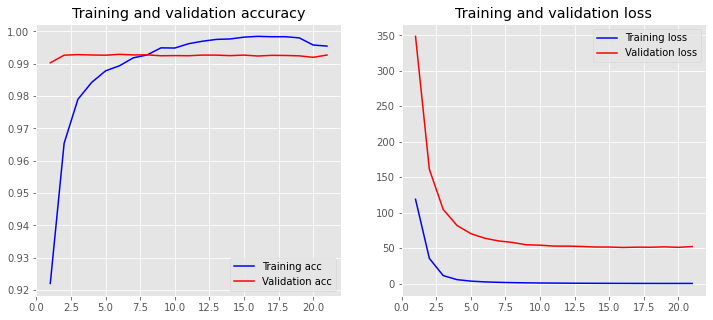

32/32 [==============================] - 10s 220ms/step
F1-score: 73.4%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.7753189792663477,0.7716269841269842,0.7734685759745427,5040.0
Disease,0.6874860085068278,0.6918224825411129,0.6896474286997529,4439.0
micro avg,0.7339449541284404,0.7342546682139466,0.7340997785043772,9479.0
macro avg,0.7314024938865877,0.7317247333340485,0.7315580023371477,9479.0
weighted avg,0.7341869445367867,0.7342546682139466,0.7342152715381263,9479.0

!!!!!! Starting model number 2 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 1250
Points in y_train after augmentation: 1250
Converted 11006 words (7785 misses)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 651, 100)          1879200   
                                                                 
 bidirectional_1 (Bidirectio  (None, 651, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_1 (TimeDis  (None, 651, 5)           1005      
 tributed)                                                       
                                                                 
 crf_1 (CRF)                 (None, 651, 5)            25        
                                                                 
Total params: 2,041,030
Trainable params: 2,041,030
Non-trainabl

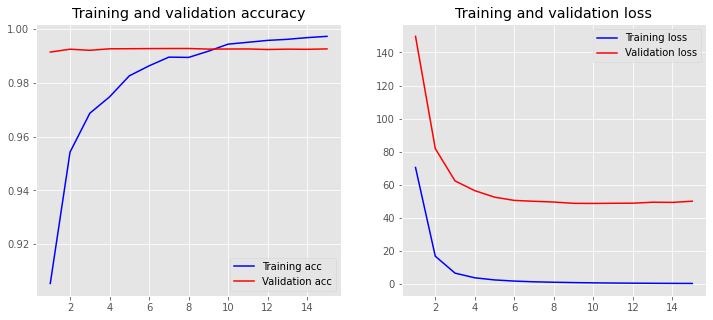

32/32 [==============================] - 11s 231ms/step
F1-score: 73.6%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.8138216699367778,0.7406746031746032,0.7755271631868703,5040.0
Disease,0.7037122969837587,0.6832619959450327,0.6933363813007201,4439.0
micro avg,0.7604810610318085,0.7137883743010867,0.7363952982150631,9479.0
macro avg,0.7587669834602683,0.711968299559818,0.7344317722437952,9479.0
weighted avg,0.7622576329562469,0.7137883743010867,0.7370373561615912,9479.0

!!!!!! Starting model number 3 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 1250
Points in y_train after augmentation: 1250
Converted 10986 words (7747 misses)
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 651, 100)          1873400   
                                                                 
 bidirectional_2 (Bidirectio  (None, 651, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_2 (TimeDis  (None, 651, 5)           1005      
 tributed)                                                       
                                                                 
 crf_2 (CRF)                 (None, 651, 5)            25        
                                                                 
Total params: 2,035,230
Trainable params: 2,035,230
Non-trainabl

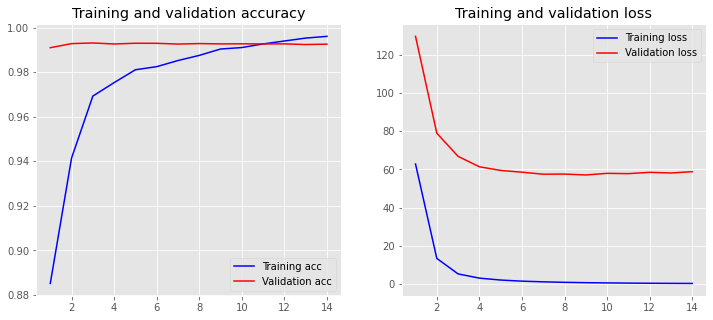

32/32 [==============================] - 10s 223ms/step
F1-score: 73.8%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.7865741685370332,0.7648809523809523,0.7755758977970022,5040.0
Disease,0.696271186440678,0.6940752421716603,0.6951714801444044,4439.0
micro avg,0.7437272142397598,0.731722755564933,0.7376761499601171,9479.0
macro avg,0.7414226774888556,0.7294780972763063,0.7353736889707033,9479.0
weighted avg,0.7442854315894943,0.731722755564933,0.7379226421835533,9479.0

!!!!!! Starting model number 4 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 1250
Points in y_train after augmentation: 1250
Converted 10964 words (7753 misses)
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 651, 100)          1871800   
                                                                 
 bidirectional_3 (Bidirectio  (None, 651, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_3 (TimeDis  (None, 651, 5)           1005      
 tributed)                                                       
                                                                 
 crf_3 (CRF)                 (None, 651, 5)            25        
                                                                 
Total params: 2,033,630
Trainable params: 2,033,630
Non-trainabl

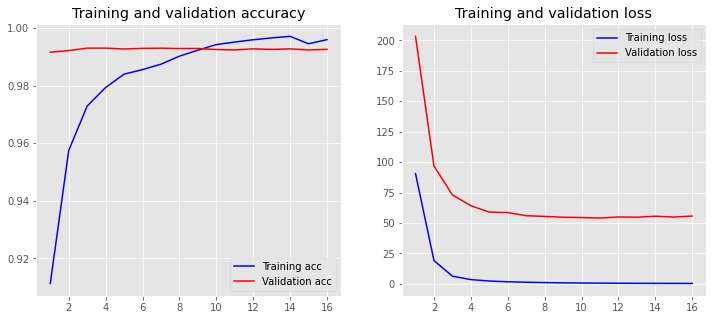

32/32 [==============================] - 10s 223ms/step
F1-score: 73.5%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.7553984330212116,0.7843253968253968,0.7695901878711184,5040.0
Disease,0.7028901734104046,0.6848389276864159,0.6937471474212689,4439.0
micro avg,0.731638418079096,0.7377360481063403,0.7346745810789514,9479.0
macro avg,0.729144303215808,0.7345821622559063,0.7316686676461936,9479.0
weighted avg,0.7308089020145261,0.7377360481063403,0.7340730176467402,9479.0

!!!!!! Starting model number 5 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 1250
Points in y_train after augmentation: 1250
Converted 10985 words (7759 misses)
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 651, 100)          1874500   
                                                                 
 bidirectional_4 (Bidirectio  (None, 651, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_4 (TimeDis  (None, 651, 5)           1005      
 tributed)                                                       
                                                                 
 crf_4 (CRF)                 (None, 651, 5)            25        
                                                                 
Total params: 2,036,330
Trainable params: 2,036,330
Non-trainabl

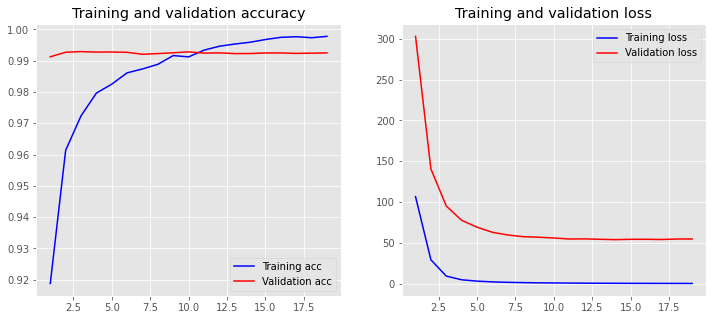

32/32 [==============================] - 10s 224ms/step
F1-score: 72.5%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.7448591012947449,0.7761904761904762,0.7602020987174505,5040.0
Disease,0.6844234659474039,0.6859653075016896,0.6851935193519353,4439.0
micro avg,0.71714256262241,0.7339381791328199,0.7254431699687175,9479.0
macro avg,0.7146412836210744,0.731077891846083,0.7226978090346929,9479.0
weighted avg,0.7165571933606963,0.7339381791328199,0.725075705236754,9479.0

!!!!!! Starting model number 6 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 1250
Points in y_train after augmentation: 1250
Converted 10984 words (7781 misses)
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 651, 100)          1876600   
                                                                 
 bidirectional_5 (Bidirectio  (None, 651, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_5 (TimeDis  (None, 651, 5)           1005      
 tributed)                                                       
                                                                 
 crf_5 (CRF)                 (None, 651, 5)            25        
                                                                 
Total params: 2,038,430
Trainable params: 2,038,430
Non-trainabl

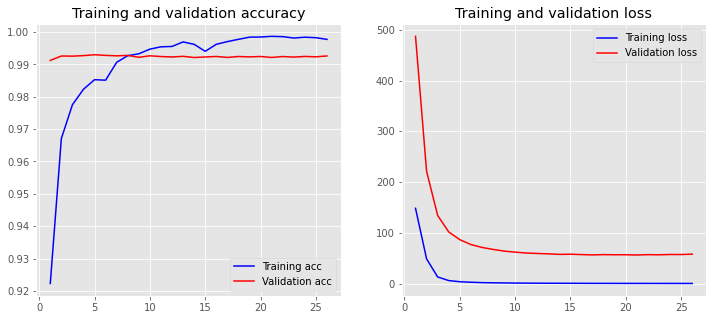

32/32 [==============================] - 10s 222ms/step
F1-score: 72.5%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.731657355679702,0.7795634920634921,0.7548511047070126,5040.0
Disease,0.6816084377059987,0.6988060373958098,0.6901001112347052,4439.0
micro avg,0.7086987198871082,0.7417449098006119,0.7248453608247423,9479.0
macro avg,0.7066328966928503,0.739184764729651,0.7224756079708589,9479.0
weighted avg,0.7082195302882821,0.7417449098006119,0.7245283217105389,9479.0

!!!!!! Starting model number 7 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 1250
Points in y_train after augmentation: 1250
Converted 10984 words (7771 misses)
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 651, 100)          1875600   
                                                                 
 bidirectional_6 (Bidirectio  (None, 651, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_6 (TimeDis  (None, 651, 5)           1005      
 tributed)                                                       
                                                                 
 crf_6 (CRF)                 (None, 651, 5)            25        
                                                                 
Total params: 2,037,430
Trainable params: 2,037,430
Non-trainabl

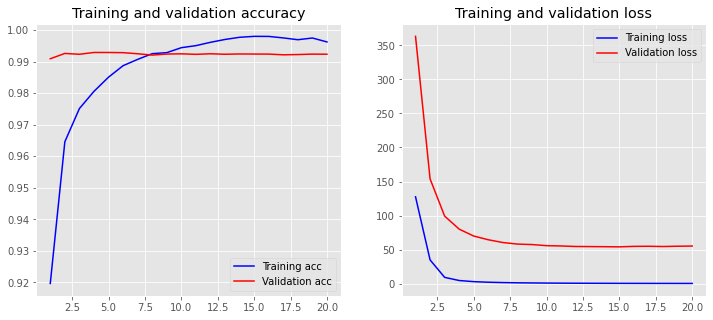

32/32 [==============================] - 10s 218ms/step
F1-score: 72.1%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.7410953657602452,0.7678571428571429,0.7542389397778211,5040.0
Disease,0.6795186093158012,0.6868664113539086,0.683172753753081,4439.0
micro avg,0.7126377587805129,0.7299293174385484,0.7211799041067335,9479.0
macro avg,0.7103069875380232,0.7273617771055257,0.718705846765451,9479.0
weighted avg,0.7122590727064539,0.7299293174385484,0.7209587625688516,9479.0

!!!!!! Starting model number 8 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 1250
Points in y_train after augmentation: 1250
Converted 10980 words (7762 misses)
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 651, 100)          1874300   
                                                                 
 bidirectional_7 (Bidirectio  (None, 651, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_7 (TimeDis  (None, 651, 5)           1005      
 tributed)                                                       
                                                                 
 crf_7 (CRF)                 (None, 651, 5)            25        
                                                                 
Total params: 2,036,130
Trainable params: 2,036,130
Non-trainabl

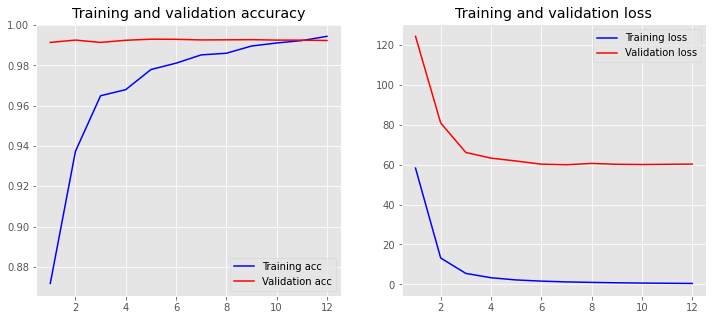

32/32 [==============================] - 11s 240ms/step
F1-score: 73.7%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.8896534148827727,0.6926587301587301,0.7788933511825079,5040.0
Disease,0.6866886688668867,0.7030862806938499,0.6947907390917186,4439.0
micro avg,0.7807297201558625,0.6975419348032493,0.7367951860931581,9479.0
macro avg,0.7881710418748298,0.69787250542629,0.7368420451371133,9479.0
weighted avg,0.7946053604925924,0.6975419348032493,0.739508237238947,9479.0

!!!!!! Starting model number 9 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 1250
Points in y_train after augmentation: 1250
Converted 10982 words (7789 misses)
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 651, 100)          1877200   
                                                                 
 bidirectional_8 (Bidirectio  (None, 651, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_8 (TimeDis  (None, 651, 5)           1005      
 tributed)                                                       
                                                                 
 crf_8 (CRF)                 (None, 651, 5)            25        
                                                                 
Total params: 2,039,030
Trainable params: 2,039,030
Non-trainabl

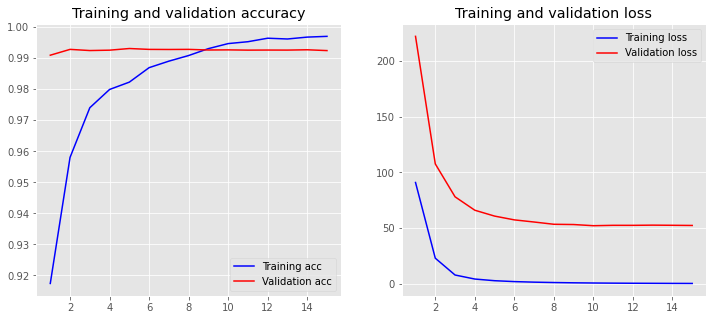

32/32 [==============================] - 11s 224ms/step
F1-score: 73.0%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.7568353694008144,0.7744047619047619,0.7655192703736393,5040.0
Disease,0.6897331524197196,0.6870916873169632,0.6884098860173794,4439.0
micro avg,0.7258586491283014,0.7335161936913176,0.7296673313044392,9479.0
macro avg,0.723284260910267,0.7307482246108625,0.7269645781955094,9479.0
weighted avg,0.7254115123294904,0.7335161936913176,0.7294090733953253,9479.0

!!!!!! Starting model number 10 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 1250
Points in y_train after augmentation: 1250
Converted 10973 words (7765 misses)
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 651, 100)          1873900   
                                                                 
 bidirectional_9 (Bidirectio  (None, 651, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_9 (TimeDis  (None, 651, 5)           1005      
 tributed)                                                       
                                                                 
 crf_9 (CRF)                 (None, 651, 5)            25        
                                                                 
Total params: 2,035,730
Trainable params: 2,035,730
Non-trainabl

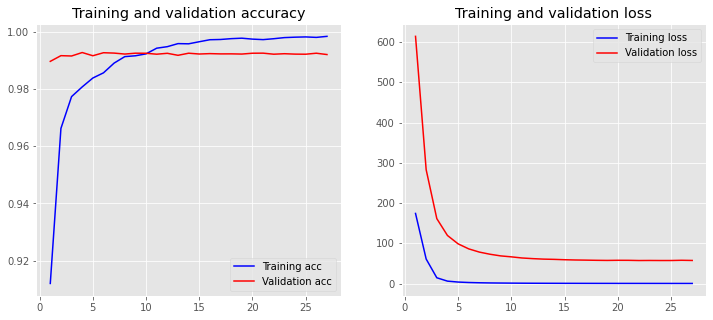

32/32 [==============================] - 10s 225ms/step
F1-score: 71.8%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.7862920391656024,0.7329365079365079,0.7586773464777162,5040.0
Disease,0.6688067301306176,0.6805586843883757,0.6746315319338989,4439.0
micro avg,0.7287032013022247,0.7084080599219327,0.7184123248100996,9479.0
macro avg,0.72754938464811,0.7067475961624419,0.7166544392058076,9479.0
weighted avg,0.7312738635345972,0.7084080599219327,0.7193188307313289,9479.0



In [ ]:
number_of_training_models = 10
target_augmented_percentage = 0.25

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 50.0% !!!!!!
!!!!!! Starting model number 1 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 1500
Points in y_train after augmentation: 1500
Converted 11063 words (7841 misses)
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 651, 100)          1890500   
                                                                 
 bidirectional_10 (Bidirecti  (None, 651, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_10 (TimeDi  (None, 651, 5)           1005      
 stributed)                                                      
                                                                 
 crf_10 (CRF)                (None, 651, 5)            25        
                                                                 
Total params: 2,052,330
Trainable params: 2,052,330
Non-trainab

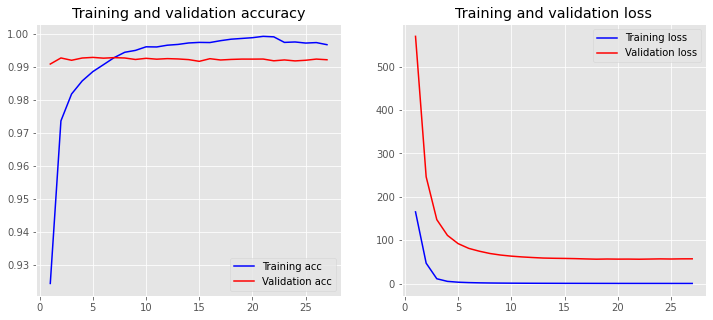

32/32 [==============================] - 10s 227ms/step
F1-score: 71.5%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.7703643061809251,0.7468253968253968,0.7584122506548459,5040.0
Disease,0.6431699687174139,0.6947510700608245,0.6679662118258608,4439.0
micro avg,0.7073649416382605,0.7224390758518832,0.7148225469728601,9479.0
macro avg,0.7067671374491695,0.7207882334431106,0.7131892312403534,9479.0
weighted avg,0.7107994086178355,0.7224390758518832,0.7160565204763603,9479.0

!!!!!! Starting model number 2 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 1500
Points in y_train after augmentation: 1500
Converted 11070 words (7853 misses)
Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, 651, 100)          1892400   
                                                                 
 bidirectional_11 (Bidirecti  (None, 651, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_11 (TimeDi  (None, 651, 5)           1005      
 stributed)                                                      
                                                                 
 crf_11 (CRF)                (None, 651, 5)            25        
                                                                 
Total params: 2,054,230
Trainable params: 2,054,230
Non-trainab

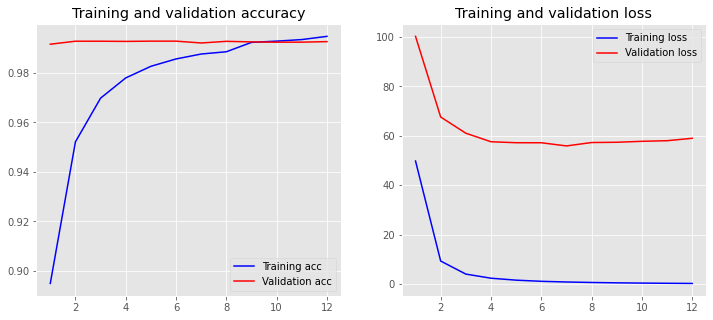

32/32 [==============================] - 10s 226ms/step
F1-score: 73.0%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.8163221360895779,0.7521825396825397,0.7829409334985543,5040.0
Disease,0.6443394288062462,0.7064654201396711,0.673973780356759,4439.0
micro avg,0.7283145831142888,0.7307732883215529,0.7295418641390207,9479.0
macro avg,0.730330782447912,0.7293239799111053,0.7284573569276567,9479.0
weighted avg,0.7357829191225234,0.7307732883215529,0.7319117961637691,9479.0

!!!!!! Starting model number 3 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 1500
Points in y_train after augmentation: 1500
Converted 11020 words (7813 misses)
Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_12 (Embedding)    (None, 651, 100)          1883400   
                                                                 
 bidirectional_12 (Bidirecti  (None, 651, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_12 (TimeDi  (None, 651, 5)           1005      
 stributed)                                                      
                                                                 
 crf_12 (CRF)                (None, 651, 5)            25        
                                                                 
Total params: 2,045,230
Trainable params: 2,045,230
Non-trainab

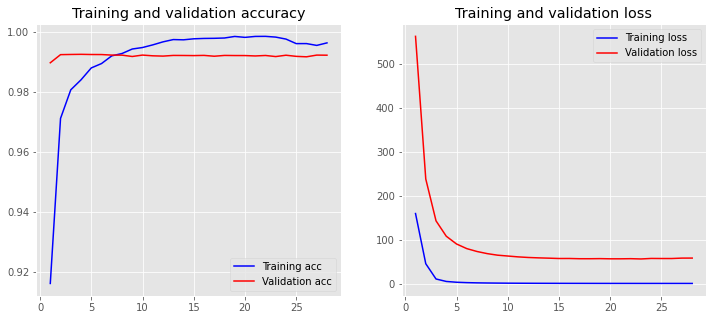

32/32 [==============================] - 10s 214ms/step
F1-score: 71.1%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.7564332734889287,0.7523809523809524,0.7544016711429423,5040.0
Disease,0.6436417405999155,0.686415859427799,0.6643410007631091,4439.0
micro avg,0.7016517902944496,0.721489608608503,0.7114324352439404,9479.0
macro avg,0.7000375070444221,0.7193984059043756,0.7093713359530257,9479.0
weighted avg,0.7036131854528143,0.721489608608503,0.7122264083709116,9479.0

!!!!!! Starting model number 4 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 1500
Points in y_train after augmentation: 1500
Converted 11030 words (7812 misses)
Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_13 (Embedding)    (None, 651, 100)          1884300   
                                                                 
 bidirectional_13 (Bidirecti  (None, 651, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_13 (TimeDi  (None, 651, 5)           1005      
 stributed)                                                      
                                                                 
 crf_13 (CRF)                (None, 651, 5)            25        
                                                                 
Total params: 2,046,130
Trainable params: 2,046,130
Non-trainab

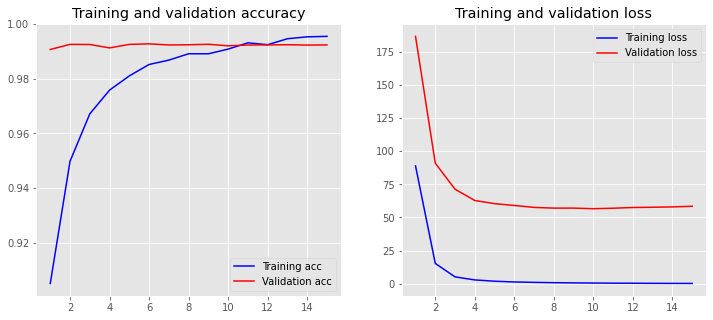

32/32 [==============================] - 11s 230ms/step
F1-score: 71.9%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.7826719301890712,0.7474206349206349,0.7646402111032172,5040.0
Disease,0.6554549374730487,0.6848389276864159,0.6698248319929493,4439.0
micro avg,0.7202412443127711,0.7181137250764849,0.719175911251981,9479.0
macro avg,0.71906343383106,0.7161297813035254,0.7172325215480833,9479.0
weighted avg,0.7230964232087543,0.7181137250764849,0.7202383261079139,9479.0

!!!!!! Starting model number 5 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 1500
Points in y_train after augmentation: 1500
Converted 11047 words (7834 misses)
Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_14 (Embedding)    (None, 651, 100)          1888200   
                                                                 
 bidirectional_14 (Bidirecti  (None, 651, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_14 (TimeDi  (None, 651, 5)           1005      
 stributed)                                                      
                                                                 
 crf_14 (CRF)                (None, 651, 5)            25        
                                                                 
Total params: 2,050,030
Trainable params: 2,050,030
Non-trainab

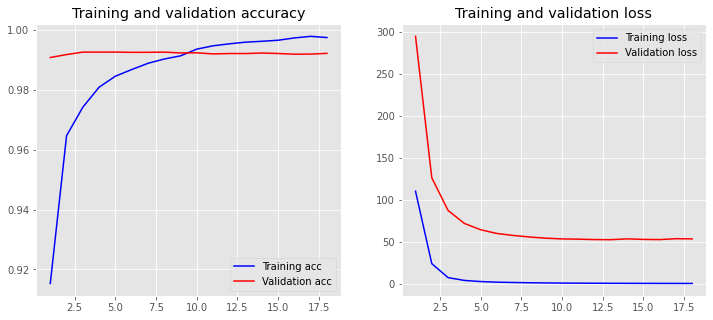

32/32 [==============================] - 10s 223ms/step
F1-score: 71.2%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.7153096857195369,0.7722222222222223,0.7426772254555863,5040.0
Disease,0.6814543791447519,0.6713223699031313,0.6763504312301407,4439.0
micro avg,0.7002241695536988,0.7249709885008967,0.7123827294873788,9479.0
macro avg,0.6983820324321444,0.7217722960626768,0.7095138283428635,9479.0
weighted avg,0.6994553017248676,0.7249709885008967,0.7116164975764058,9479.0

!!!!!! Starting model number 6 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 1500
Points in y_train after augmentation: 1500
Converted 11060 words (7827 misses)
Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_15 (Embedding)    (None, 651, 100)          1888800   
                                                                 
 bidirectional_15 (Bidirecti  (None, 651, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_15 (TimeDi  (None, 651, 5)           1005      
 stributed)                                                      
                                                                 
 crf_15 (CRF)                (None, 651, 5)            25        
                                                                 
Total params: 2,050,630
Trainable params: 2,050,630
Non-trainab

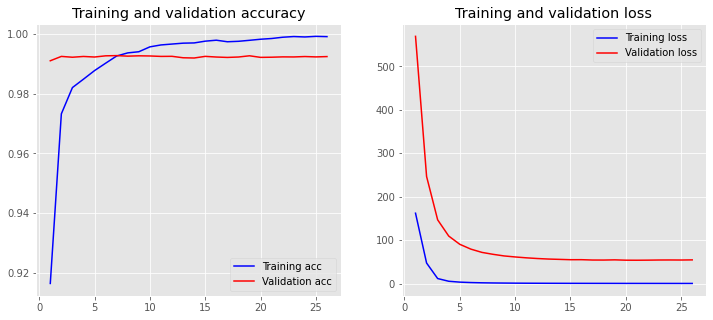

32/32 [==============================] - 11s 228ms/step
F1-score: 72.2%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.7851554239796997,0.7367063492063493,0.7601596888115468,5040.0
Disease,0.6800450958286358,0.679432304573102,0.6797385620915033,4439.0
micro avg,0.7342863378437363,0.7098850089671906,0.7218795258273882,9479.0
macro avg,0.7326002599041678,0.7080693268897256,0.7199491254515251,9479.0
weighted avg,0.7359324314000424,0.7098850089671906,0.7224986083694883,9479.0

!!!!!! Starting model number 7 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 1500
Points in y_train after augmentation: 1500
Converted 11048 words (7816 misses)
Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_16 (Embedding)    (None, 651, 100)          1886500   
                                                                 
 bidirectional_16 (Bidirecti  (None, 651, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_16 (TimeDi  (None, 651, 5)           1005      
 stributed)                                                      
                                                                 
 crf_16 (CRF)                (None, 651, 5)            25        
                                                                 
Total params: 2,048,330
Trainable params: 2,048,330
Non-trainab

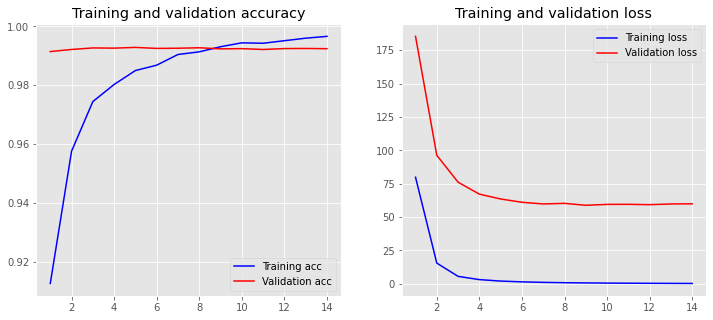

32/32 [==============================] - 10s 217ms/step
F1-score: 72.5%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.7348242811501597,0.7757936507936508,0.7547534021812567,5040.0
Disease,0.701301720130172,0.6796575805361568,0.690310033176982,4439.0
micro avg,0.7198378883923933,0.7307732883215529,0.7252643702230134,9479.0
macro avg,0.7180630006401658,0.7277256156649038,0.7225317176791194,9479.0
weighted avg,0.7191257213476778,0.7307732883215529,0.7245746792136467,9479.0

!!!!!! Starting model number 8 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 1500
Points in y_train after augmentation: 1500
Converted 11027 words (7813 misses)
Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_17 (Embedding)    (None, 651, 100)          1884100   
                                                                 
 bidirectional_17 (Bidirecti  (None, 651, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_17 (TimeDi  (None, 651, 5)           1005      
 stributed)                                                      
                                                                 
 crf_17 (CRF)                (None, 651, 5)            25        
                                                                 
Total params: 2,045,930
Trainable params: 2,045,930
Non-trainab

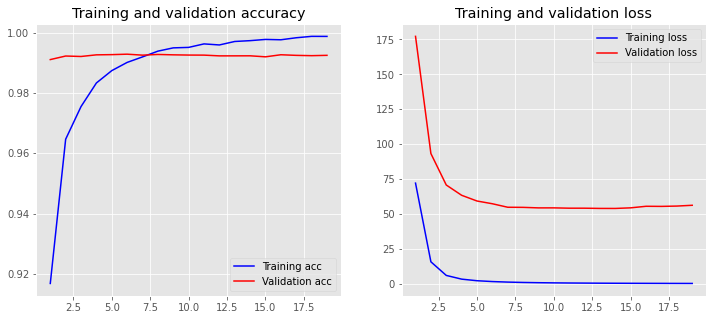

32/32 [==============================] - 10s 224ms/step
F1-score: 72.3%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.7425366039170945,0.7748015873015873,0.7583260510729196,5040.0
Disease,0.6746696035242291,0.6900202748366749,0.6822586034079519,4439.0
micro avg,0.7110929686702725,0.7350986390969512,0.722896566033821,9479.0
macro avg,0.7086031037206618,0.7324109310691311,0.7202923272404358,9479.0
weighted avg,0.7107546000407438,0.7350986390969512,0.7227037913213855,9479.0

!!!!!! Starting model number 9 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 1500
Points in y_train after augmentation: 1500
Converted 11053 words (7822 misses)
Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_18 (Embedding)    (None, 651, 100)          1887600   
                                                                 
 bidirectional_18 (Bidirecti  (None, 651, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_18 (TimeDi  (None, 651, 5)           1005      
 stributed)                                                      
                                                                 
 crf_18 (CRF)                (None, 651, 5)            25        
                                                                 
Total params: 2,049,430
Trainable params: 2,049,430
Non-trainab

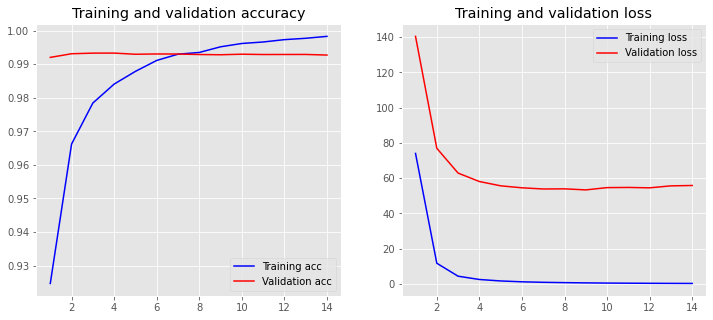

32/32 [==============================] - 10s 223ms/step
F1-score: 73.9%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.7844395428113095,0.7761904761904762,0.7802932083374888,5040.0
Disease,0.6922730344672223,0.6922730344672223,0.6922730344672223,4439.0
micro avg,0.7410354339062168,0.7368920772233358,0.7389579476329013,9479.0
macro avg,0.7383562886392658,0.7342317553288493,0.7362831214023555,9479.0
weighted avg,0.741278119608503,0.7368920772233358,0.7390735067012284,9479.0

!!!!!! Starting model number 10 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 1500
Points in y_train after augmentation: 1500
Converted 11055 words (7822 misses)
Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_19 (Embedding)    (None, 651, 100)          1887800   
                                                                 
 bidirectional_19 (Bidirecti  (None, 651, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_19 (TimeDi  (None, 651, 5)           1005      
 stributed)                                                      
                                                                 
 crf_19 (CRF)                (None, 651, 5)            25        
                                                                 
Total params: 2,049,630
Trainable params: 2,049,630
Non-trainab

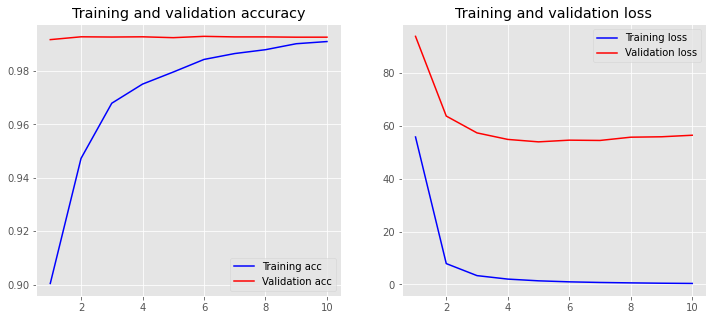

32/32 [==============================] - 11s 233ms/step
F1-score: 73.6%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.8132516947299366,0.7378968253968254,0.7737438884843442,5040.0
Disease,0.6822125813449024,0.7084929038071638,0.6951044314288872,4439.0
micro avg,0.747468147664162,0.7241270176178922,0.7356124745472084,9479.0
macro avg,0.7477321380374196,0.7231948646019946,0.7344241599566157,9479.0
weighted avg,0.7518862949708727,0.7241270176178922,0.7369171609952447,9479.0



In [ ]:
number_of_training_models = 10
target_augmented_percentage = 0.5

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 75.0% !!!!!!
!!!!!! Starting model number 1 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 1750
Points in y_train after augmentation: 1750
Converted 11121 words (7875 misses)
Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_20 (Embedding)    (None, 651, 100)          1899700   
                                                                 
 bidirectional_20 (Bidirecti  (None, 651, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_20 (TimeDi  (None, 651, 5)           1005      
 stributed)                                                      
                                                                 
 crf_20 (CRF)                (None, 651, 5)            25        
                                                                 
Total params: 2,061,530
Trainable params: 2,061,530
Non-trainab

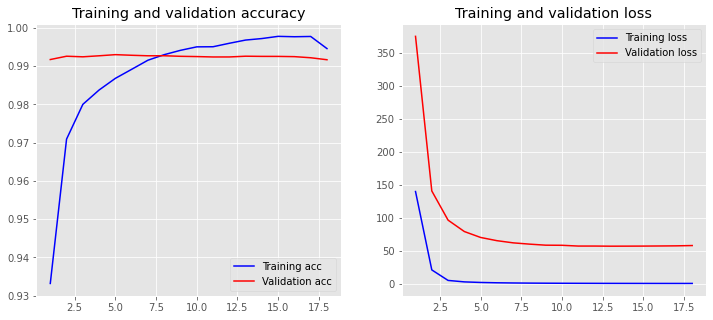

32/32 [==============================] - 10s 213ms/step
F1-score: 73.4%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.8434097753069261,0.7224206349206349,0.7782408891738806,5040.0
Disease,0.688728258414276,0.6868664113539086,0.6877960748928491,4439.0
micro avg,0.765096065873742,0.7057706509125435,0.7342369533007738,9479.0
macro avg,0.766069016860601,0.7046435231372717,0.7330184820333648,9479.0
weighted avg,0.7709726771439896,0.7057706509125435,0.7358857324491734,9479.0

!!!!!! Starting model number 2 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 1750
Points in y_train after augmentation: 1750
Converted 11130 words (7907 misses)
Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_21 (Embedding)    (None, 651, 100)          1903800   
                                                                 
 bidirectional_21 (Bidirecti  (None, 651, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_21 (TimeDi  (None, 651, 5)           1005      
 stributed)                                                      
                                                                 
 crf_21 (CRF)                (None, 651, 5)            25        
                                                                 
Total params: 2,065,630
Trainable params: 2,065,630
Non-trainab

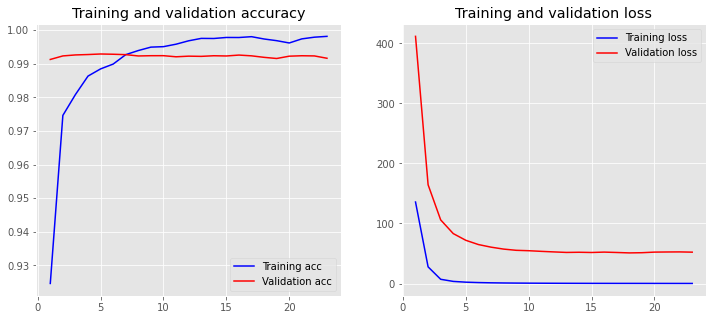

32/32 [==============================] - 10s 224ms/step
F1-score: 71.2%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.6876412306622631,0.7849206349206349,0.7330677290836652,5040.0
Disease,0.6955617198335645,0.6778553728317188,0.686594409583571,4439.0
micro avg,0.6910407778549459,0.7347821500158245,0.7122405153901217,9479.0
macro avg,0.6916014752479138,0.7313880038761769,0.7098310693336181,9479.0
weighted avg,0.691350382622534,0.7347821500158245,0.7113043505351982,9479.0

!!!!!! Starting model number 3 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 1750
Points in y_train after augmentation: 1750
Converted 11115 words (7887 misses)
Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_22 (Embedding)    (None, 651, 100)          1900300   
                                                                 
 bidirectional_22 (Bidirecti  (None, 651, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_22 (TimeDi  (None, 651, 5)           1005      
 stributed)                                                      
                                                                 
 crf_22 (CRF)                (None, 651, 5)            25        
                                                                 
Total params: 2,062,130
Trainable params: 2,062,130
Non-trainab

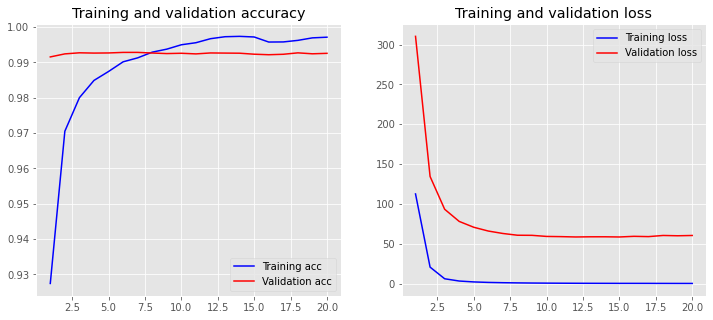

32/32 [==============================] - 10s 216ms/step
F1-score: 72.5%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.7943428328370906,0.7410714285714286,0.7667830014370766,5040.0
Disease,0.6852745233172525,0.6719981977922955,0.6785714285714285,4439.0
micro avg,0.7419105466593042,0.7087245490030594,0.7249379518722349,9479.0
macro avg,0.7398086780771715,0.7065348131818621,0.7226772150042525,9479.0
weighted avg,0.7432663241380125,0.7087245490030594,0.7254736679682917,9479.0

!!!!!! Starting model number 4 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 1750
Points in y_train after augmentation: 1750
Converted 11146 words (7905 misses)
Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_23 (Embedding)    (None, 651, 100)          1905200   
                                                                 
 bidirectional_23 (Bidirecti  (None, 651, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_23 (TimeDi  (None, 651, 5)           1005      
 stributed)                                                      
                                                                 
 crf_23 (CRF)                (None, 651, 5)            25        
                                                                 
Total params: 2,067,030
Trainable params: 2,067,030
Non-trainab

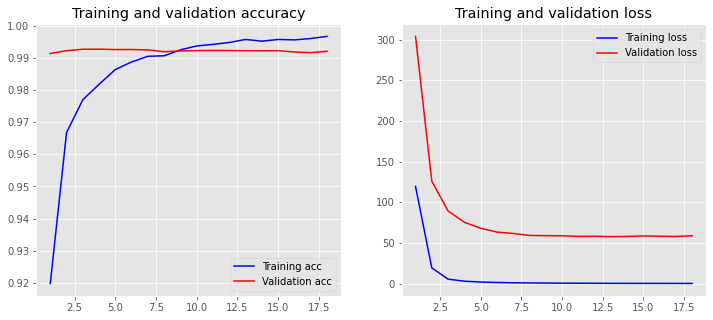

32/32 [==============================] - 10s 214ms/step
F1-score: 71.3%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.7810850749419463,0.7341269841269841,0.7568783880535952,5040.0
Disease,0.6580105633802817,0.6735751295336787,0.6657018813314037,4439.0
micro avg,0.7208274970369573,0.7057706509125435,0.7132196162046908,9479.0
macro avg,0.719547819161114,0.7038510568303313,0.7112901346924995,9479.0
weighted avg,0.7234494850250532,0.7057706509125435,0.7141805809705898,9479.0

!!!!!! Starting model number 5 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 1750
Points in y_train after augmentation: 1750
Converted 11140 words (7876 misses)
Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_24 (Embedding)    (None, 651, 100)          1901700   
                                                                 
 bidirectional_24 (Bidirecti  (None, 651, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_24 (TimeDi  (None, 651, 5)           1005      
 stributed)                                                      
                                                                 
 crf_24 (CRF)                (None, 651, 5)            25        
                                                                 
Total params: 2,063,530
Trainable params: 2,063,530
Non-trainab

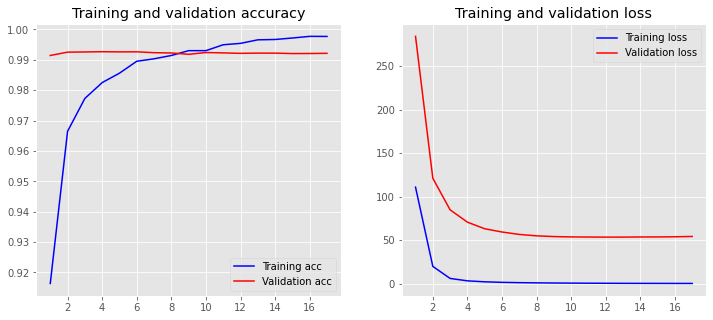

32/32 [==============================] - 10s 216ms/step
F1-score: 72.3%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.7878787878787878,0.7325396825396825,0.7592021385975736,5040.0
Disease,0.697282099343955,0.6704212660509123,0.6835879177673136,4439.0
micro avg,0.744695108331472,0.7034497309842811,0.7234850539792764,9479.0
macro avg,0.7425804436113714,0.7014804742952974,0.7213950281824436,9479.0
weighted avg,0.7454525086925738,0.7034497309842811,0.7237921242220569,9479.0

!!!!!! Starting model number 6 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 1750
Points in y_train after augmentation: 1750
Converted 11103 words (7867 misses)
Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_25 (Embedding)    (None, 651, 100)          1897100   
                                                                 
 bidirectional_25 (Bidirecti  (None, 651, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_25 (TimeDi  (None, 651, 5)           1005      
 stributed)                                                      
                                                                 
 crf_25 (CRF)                (None, 651, 5)            25        
                                                                 
Total params: 2,058,930
Trainable params: 2,058,930
Non-trainab

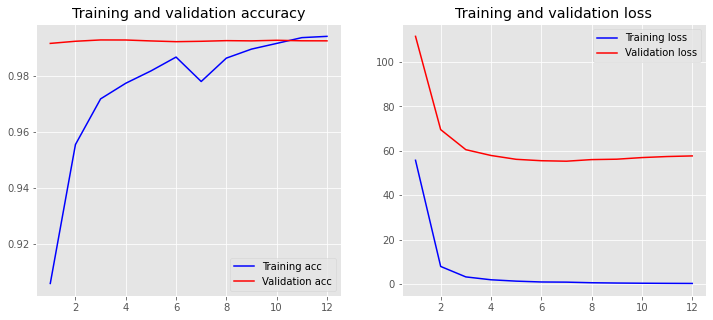

32/32 [==============================] - 10s 222ms/step
F1-score: 72.2%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.7707736389684814,0.7472222222222222,0.7588152327221438,5040.0
Disease,0.6926124446515963,0.6695201621986934,0.6808705612829324,4439.0
micro avg,0.7342268715266427,0.7108344762105707,0.7223413379073756,9479.0
macro avg,0.7316930418100389,0.7083711922104579,0.7198428970025381,9479.0
weighted avg,0.734170881127712,0.7108344762105707,0.7223138721863638,9479.0

!!!!!! Starting model number 7 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 1750
Points in y_train after augmentation: 1750
Converted 11106 words (7882 misses)
Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_26 (Embedding)    (None, 651, 100)          1898900   
                                                                 
 bidirectional_26 (Bidirecti  (None, 651, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_26 (TimeDi  (None, 651, 5)           1005      
 stributed)                                                      
                                                                 
 crf_26 (CRF)                (None, 651, 5)            25        
                                                                 
Total params: 2,060,730
Trainable params: 2,060,730
Non-trainab

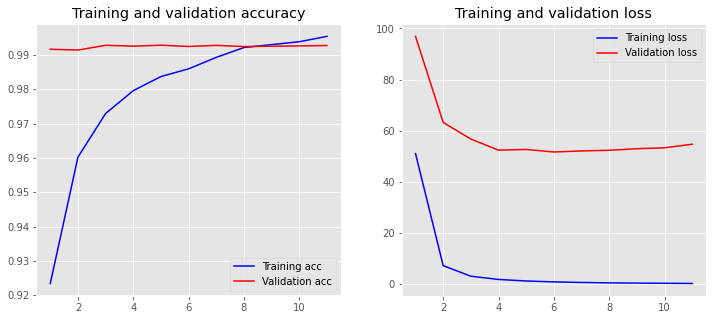

32/32 [==============================] - 10s 217ms/step
F1-score: 73.5%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.7666600751433656,0.7692460317460318,0.7679508764979697,5040.0
Disease,0.7204638801642909,0.6717729218292409,0.6952669619958033,4439.0
micro avg,0.7458677685950413,0.7235995358160143,0.7345649263721553,9479.0
macro avg,0.7435619776538283,0.7205094767876363,0.7316089192468864,9479.0
weighted avg,0.7450264735490928,0.7235995358160143,0.7339131197224537,9479.0

!!!!!! Starting model number 8 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 1750
Points in y_train after augmentation: 1750
Converted 11106 words (7877 misses)
Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_27 (Embedding)    (None, 651, 100)          1898400   
                                                                 
 bidirectional_27 (Bidirecti  (None, 651, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_27 (TimeDi  (None, 651, 5)           1005      
 stributed)                                                      
                                                                 
 crf_27 (CRF)                (None, 651, 5)            25        
                                                                 
Total params: 2,060,230
Trainable params: 2,060,230
Non-trainab

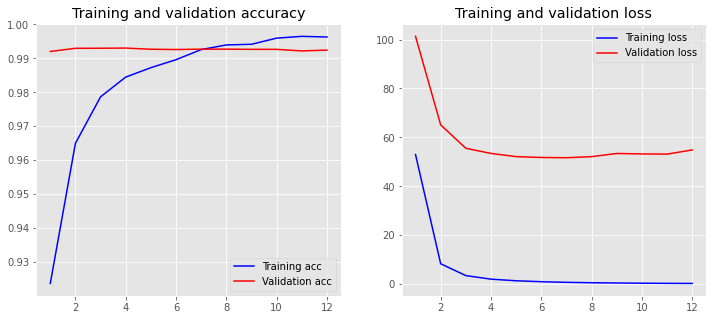

32/32 [==============================] - 10s 217ms/step
F1-score: 73.7%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.8061485909479078,0.7492063492063492,0.7766351295763061,5040.0
Disease,0.6896167557932263,0.6972291056544266,0.6934020387588216,4439.0
micro avg,0.7491277802006105,0.7248654921405212,0.7367969545868854,9479.0
macro avg,0.747882673370567,0.7232177274303879,0.7350185841675638,9479.0
weighted avg,0.7515769255558168,0.7248654921405212,0.7376572110048519,9479.0

!!!!!! Starting model number 9 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 1750
Points in y_train after augmentation: 1750
Converted 11131 words (7893 misses)
Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_28 (Embedding)    (None, 651, 100)          1902500   
                                                                 
 bidirectional_28 (Bidirecti  (None, 651, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_28 (TimeDi  (None, 651, 5)           1005      
 stributed)                                                      
                                                                 
 crf_28 (CRF)                (None, 651, 5)            25        
                                                                 
Total params: 2,064,330
Trainable params: 2,064,330
Non-trainab

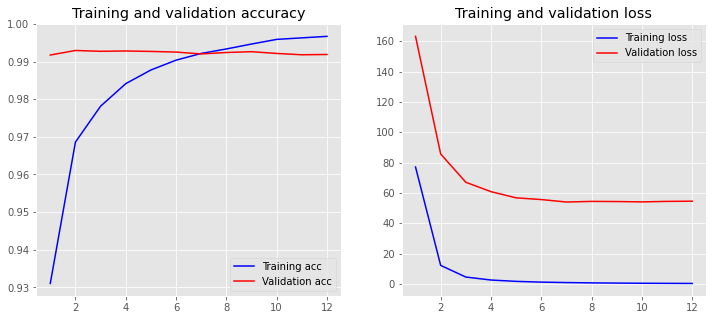

32/32 [==============================] - 10s 213ms/step
F1-score: 72.1%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.7314882697947214,0.7918650793650793,0.7604801829268293,5040.0
Disease,0.6576249466040154,0.6936246902455508,0.6751452691590835,4439.0
micro avg,0.6973762083251135,0.745859267855259,0.7208033848192894,9479.0
macro avg,0.6945566081993684,0.7427448848053151,0.7178127260429563,9479.0
weighted avg,0.6968981978838085,0.745859267855259,0.720517984149002,9479.0

!!!!!! Starting model number 10 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 1750
Points in y_train after augmentation: 1750
Converted 11125 words (7892 misses)
Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_29 (Embedding)    (None, 651, 100)          1901800   
                                                                 
 bidirectional_29 (Bidirecti  (None, 651, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_29 (TimeDi  (None, 651, 5)           1005      
 stributed)                                                      
                                                                 
 crf_29 (CRF)                (None, 651, 5)            25        
                                                                 
Total params: 2,063,630
Trainable params: 2,063,630
Non-trainab

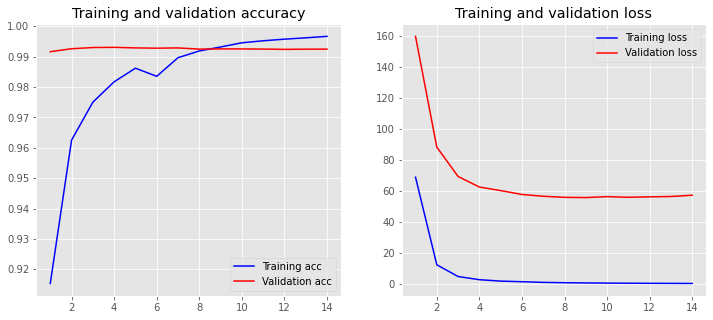

32/32 [==============================] - 10s 212ms/step
F1-score: 72.6%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.7780282844845255,0.7531746031746032,0.765399737876802,5040.0
Disease,0.6862700228832952,0.6756026132011714,0.6808945396753321,4439.0
micro avg,0.7346740188128447,0.7168477687519781,0.7256514310123879,9479.0
macro avg,0.7321491536839104,0.7143886081878873,0.7231471387760671,9479.0
weighted avg,0.7350580425552227,0.7168477687519781,0.7258260935244099,9479.0



In [ ]:
number_of_training_models = 10
target_augmented_percentage = 0.75

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 100% !!!!!!
!!!!!! Starting model number 1 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 2000
Points in y_train after augmentation: 2000
Converted 11157 words (7928 misses)
Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_30 (Embedding)    (None, 651, 100)          1908600   
                                                                 
 bidirectional_30 (Bidirecti  (None, 651, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_30 (TimeDi  (None, 651, 5)           1005      
 stributed)                                                      
                                                                 
 crf_30 (CRF)                (None, 651, 5)            25        
                                                                 
Total params: 2,070,430
Trainable params: 2,070,430
Non-trainab

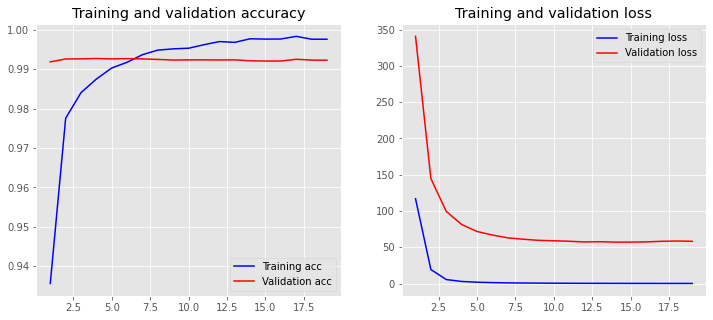

32/32 [==============================] - 10s 213ms/step
F1-score: 72.4%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.7738703741566142,0.7509920634920635,0.7622595911791361,5040.0
Disease,0.683246665159394,0.6807839603514305,0.682013089596028,4439.0
micro avg,0.730835301696371,0.7181137250764849,0.7244186665247699,9479.0
macro avg,0.7285585196580041,0.715888011921747,0.722136340387582,9479.0
weighted avg,0.731431441332618,0.7181137250764849,0.7246802873994741,9479.0

!!!!!! Starting model number 2 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 2000
Points in y_train after augmentation: 2000
Converted 11171 words (7943 misses)
Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_31 (Embedding)    (None, 651, 100)          1911500   
                                                                 
 bidirectional_31 (Bidirecti  (None, 651, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_31 (TimeDi  (None, 651, 5)           1005      
 stributed)                                                      
                                                                 
 crf_31 (CRF)                (None, 651, 5)            25        
                                                                 
Total params: 2,073,330
Trainable params: 2,073,330
Non-trainab

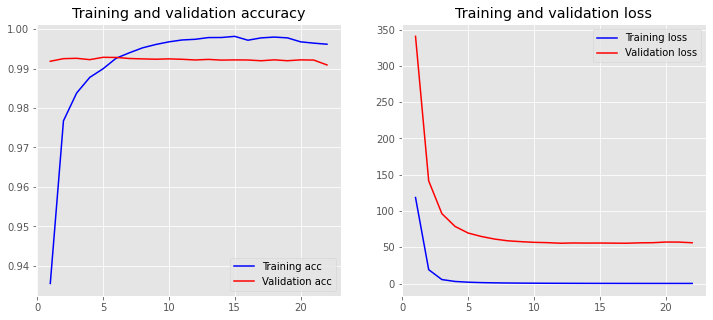

32/32 [==============================] - 10s 209ms/step
F1-score: 71.8%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.7208441318030359,0.7726190476190476,0.7458341313924535,5040.0
Disease,0.6917965169569202,0.6801081324622663,0.6859025332273088,4439.0
micro avg,0.707864018021708,0.729296339276295,0.718420368926994,9479.0
macro avg,0.706320324379978,0.726363590040657,0.7158683323098811,9479.0
weighted avg,0.7072411818819568,0.729296339276295,0.7177682632359942,9479.0

!!!!!! Starting model number 3 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 2000
Points in y_train after augmentation: 2000
Converted 11127 words (7913 misses)
Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_32 (Embedding)    (None, 651, 100)          1904100   
                                                                 
 bidirectional_32 (Bidirecti  (None, 651, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_32 (TimeDi  (None, 651, 5)           1005      
 stributed)                                                      
                                                                 
 crf_32 (CRF)                (None, 651, 5)            25        
                                                                 
Total params: 2,065,930
Trainable params: 2,065,930
Non-trainab

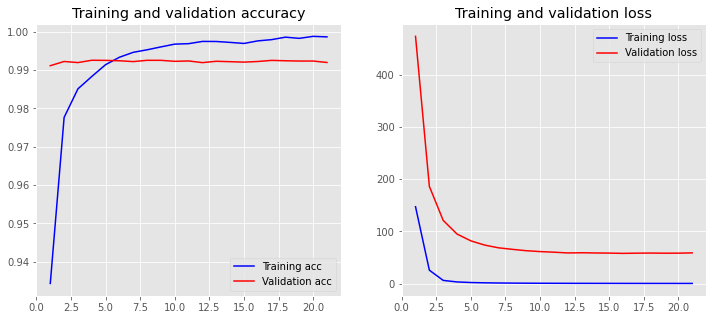

32/32 [==============================] - 10s 210ms/step
F1-score: 71.7%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.8218764514630748,0.7021825396825396,0.7573293387545474,5040.0
Disease,0.6710614525139664,0.6765037170533904,0.6737715952434372,4439.0
micro avg,0.7450176517480924,0.6901571895769596,0.7165388828039431,9479.0
macro avg,0.7464689519885206,0.689343128367965,0.7155504669989923,9479.0
weighted avg,0.751250037249013,0.6901571895769596,0.7181993858643884,9479.0

!!!!!! Starting model number 4 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 2000
Points in y_train after augmentation: 2000
Converted 11213 words (7956 misses)
Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_33 (Embedding)    (None, 651, 100)          1917000   
                                                                 
 bidirectional_33 (Bidirecti  (None, 651, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_33 (TimeDi  (None, 651, 5)           1005      
 stributed)                                                      
                                                                 
 crf_33 (CRF)                (None, 651, 5)            25        
                                                                 
Total params: 2,078,830
Trainable params: 2,078,830
Non-trainab

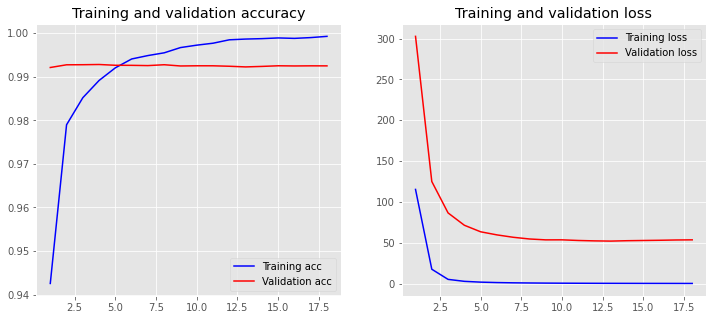

32/32 [==============================] - 10s 211ms/step
F1-score: 72.5%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.7529365700861393,0.763095238095238,0.757981868348443,5040.0
Disease,0.6870091990127889,0.6897949988736202,0.6883992805755397,4439.0
micro avg,0.7222164140094093,0.7287688574744171,0.7254778407897501,9479.0
macro avg,0.7199728845494642,0.7264451184844292,0.7231905744619913,9479.0
weighted avg,0.7220628914075232,0.7287688574744171,0.7253964577435356,9479.0

!!!!!! Starting model number 5 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 2000
Points in y_train after augmentation: 2000
Converted 11178 words (7916 misses)
Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_34 (Embedding)    (None, 651, 100)          1909500   
                                                                 
 bidirectional_34 (Bidirecti  (None, 651, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_34 (TimeDi  (None, 651, 5)           1005      
 stributed)                                                      
                                                                 
 crf_34 (CRF)                (None, 651, 5)            25        
                                                                 
Total params: 2,071,330
Trainable params: 2,071,330
Non-trainab

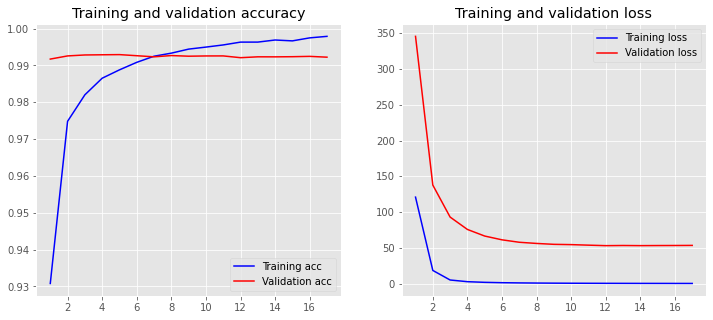

32/32 [==============================] - 10s 209ms/step
F1-score: 72.1%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.8019239177962396,0.7277777777777777,0.7630538797586853,5040.0
Disease,0.6783851213427081,0.6738004054967335,0.6760849909584087,4439.0
micro avg,0.7412891016364244,0.7025002637409009,0.7213736323258585,9479.0
macro avg,0.7401545195694739,0.7007890916372557,0.719569435358547,9479.0
weighted avg,0.7440709040334771,0.7025002637409009,0.7223264931794652,9479.0

!!!!!! Starting model number 6 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 2000
Points in y_train after augmentation: 2000
Converted 11175 words (7932 misses)
Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_35 (Embedding)    (None, 651, 100)          1910800   
                                                                 
 bidirectional_35 (Bidirecti  (None, 651, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_35 (TimeDi  (None, 651, 5)           1005      
 stributed)                                                      
                                                                 
 crf_35 (CRF)                (None, 651, 5)            25        
                                                                 
Total params: 2,072,630
Trainable params: 2,072,630
Non-trainab

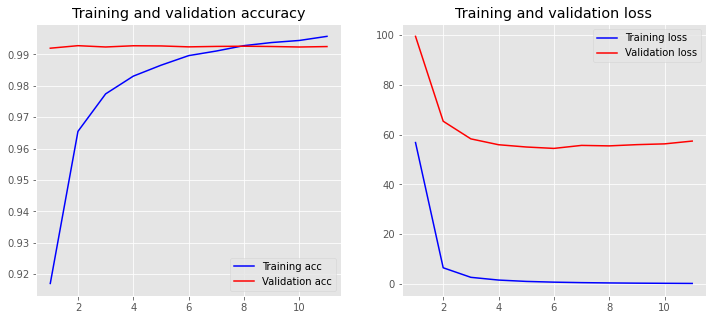

32/32 [==============================] - 10s 214ms/step
F1-score: 73.9%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.7569189084575189,0.7759920634920635,0.7663368276672872,5040.0
Disease,0.7419354838709677,0.6735751295336787,0.7061046168378793,4439.0
micro avg,0.7503533761009025,0.7280303829517881,0.739023345470122,9479.0
macro avg,0.7494271961642434,0.724783596512871,0.7362207222525832,9479.0
weighted avg,0.7499021955405761,0.7280303829517881,0.7381301830980561,9479.0

!!!!!! Starting model number 7 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 2000
Points in y_train after augmentation: 2000
Converted 11197 words (7917 misses)
Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_36 (Embedding)    (None, 651, 100)          1911500   
                                                                 
 bidirectional_36 (Bidirecti  (None, 651, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_36 (TimeDi  (None, 651, 5)           1005      
 stributed)                                                      
                                                                 
 crf_36 (CRF)                (None, 651, 5)            25        
                                                                 
Total params: 2,073,330
Trainable params: 2,073,330
Non-trainab

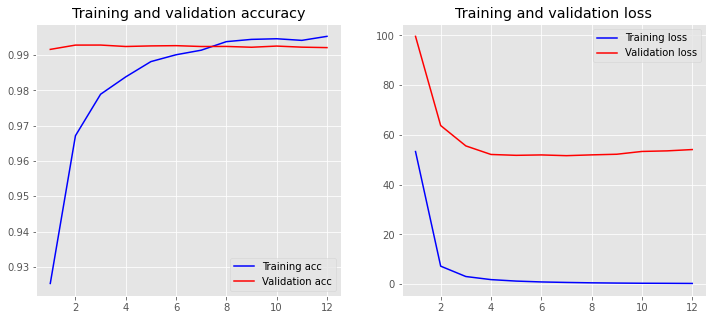

32/32 [==============================] - 10s 212ms/step
F1-score: 73.8%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.8449812382739212,0.7148809523809524,0.7745055889939811,5040.0
Disease,0.7282954267547077,0.6708718179770219,0.698405253283302,4439.0
micro avg,0.7878606488686699,0.6942715476316067,0.7381112606550023,9479.0
macro avg,0.7866383325143145,0.6928763851789872,0.7364554211386416,9479.0
weighted avg,0.7903374660053498,0.6942715476316067,0.7388679278251127,9479.0

!!!!!! Starting model number 8 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 2000
Points in y_train after augmentation: 2000
Converted 11135 words (7923 misses)
Model: "sequential_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_37 (Embedding)    (None, 651, 100)          1905900   
                                                                 
 bidirectional_37 (Bidirecti  (None, 651, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_37 (TimeDi  (None, 651, 5)           1005      
 stributed)                                                      
                                                                 
 crf_37 (CRF)                (None, 651, 5)            25        
                                                                 
Total params: 2,067,730
Trainable params: 2,067,730
Non-trainab

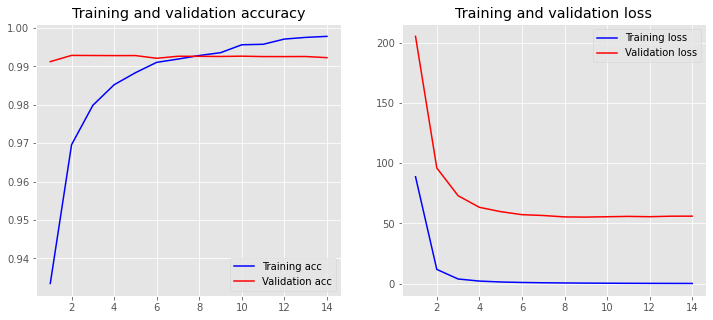

32/32 [==============================] - 10s 219ms/step
F1-score: 73.4%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.8105726872246696,0.7301587301587301,0.7682672233820459,5040.0
Disease,0.7110275099929462,0.68123451227754,0.6958122411412794,4439.0
micro avg,0.7624246559763448,0.7072475999578015,0.733800350262697,9479.0
macro avg,0.7608000986088079,0.705696621218135,0.7320397322616626,9479.0
weighted avg,0.7639558456030197,0.7072475999578015,0.7343366752053645,9479.0

!!!!!! Starting model number 9 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 2000
Points in y_train after augmentation: 2000
Converted 11173 words (7911 misses)
Model: "sequential_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_38 (Embedding)    (None, 651, 100)          1908500   
                                                                 
 bidirectional_38 (Bidirecti  (None, 651, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_38 (TimeDi  (None, 651, 5)           1005      
 stributed)                                                      
                                                                 
 crf_38 (CRF)                (None, 651, 5)            25        
                                                                 
Total params: 2,070,330
Trainable params: 2,070,330
Non-trainab

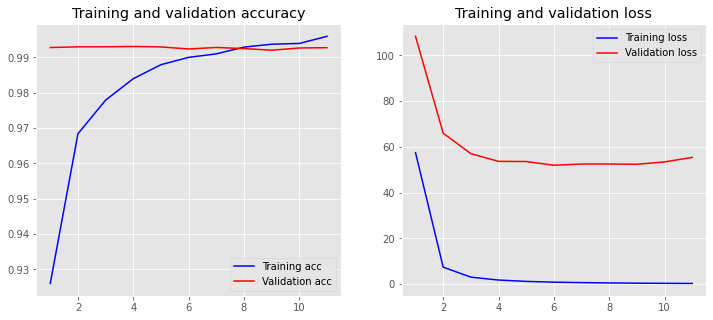

32/32 [==============================] - 10s 219ms/step
F1-score: 72.5%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.7558812186656383,0.7777777777777778,0.7666731859964795,5040.0
Disease,0.674871335869322,0.679432304573102,0.6771441400987877,4439.0
micro avg,0.7183842568617297,0.731722755564933,0.7249921605518972,9479.0
macro avg,0.7153762772674801,0.7286050411754399,0.7219086630476336,9479.0
weighted avg,0.7179444247282136,0.731722755564933,0.7247468820889097,9479.0

!!!!!! Starting model number 10 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 2000
Points in y_train after augmentation: 2000
Converted 11141 words (7930 misses)
Model: "sequential_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_39 (Embedding)    (None, 651, 100)          1907200   
                                                                 
 bidirectional_39 (Bidirecti  (None, 651, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_39 (TimeDi  (None, 651, 5)           1005      
 stributed)                                                      
                                                                 
 crf_39 (CRF)                (None, 651, 5)            25        
                                                                 
Total params: 2,069,030
Trainable params: 2,069,030
Non-trainab

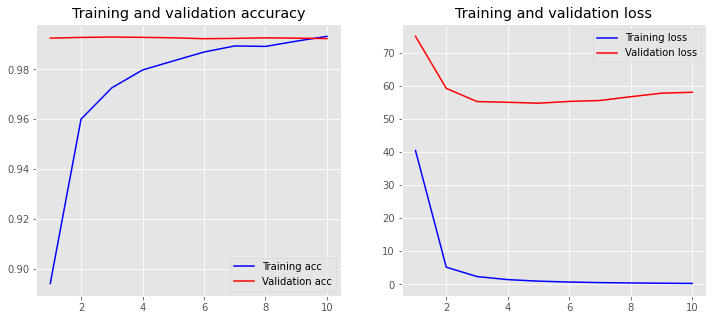

32/32 [==============================] - 10s 218ms/step
F1-score: 74.0%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.8406979379107183,0.7361111111111112,0.7849359991537077,5040.0
Disease,0.7170636849781235,0.664564091011489,0.6898164386764878,4439.0
micro avg,0.781048434384895,0.7026057601012765,0.7397534155281573,9479.0
macro avg,0.7788808114444209,0.7003376010613,0.7373762189150977,9479.0
weighted avg,0.7828002220369142,0.7026057601012765,0.7403916665280743,9479.0



In [ ]:
number_of_training_models = 10
target_augmented_percentage = 1

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 200% !!!!!!
!!!!!! Starting model number 1 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 3000
Points in y_train after augmentation: 3000
Converted 11386 words (8075 misses)
Model: "sequential_40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_40 (Embedding)    (None, 651, 100)          1946200   
                                                                 
 bidirectional_40 (Bidirecti  (None, 651, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_40 (TimeDi  (None, 651, 5)           1005      
 stributed)                                                      
                                                                 
 crf_40 (CRF)                (None, 651, 5)            25        
                                                                 
Total params: 2,108,030
Trainable params: 2,108,030
Non-trainab

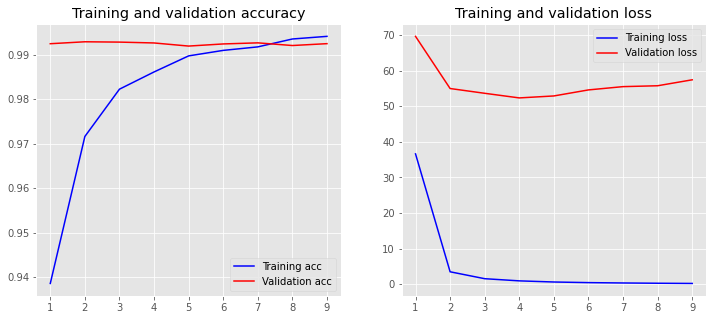

32/32 [==============================] - 10s 213ms/step
F1-score: 73.5%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.8602673147023087,0.7023809523809523,0.7733478973238667,5040.0
Disease,0.7061699650756694,0.6832619959450327,0.6945271353331806,4439.0
micro avg,0.7815695600475624,0.6934275767486022,0.734865000838504,9479.0
macro avg,0.7832186398889891,0.6928214741629926,0.7339375163285236,9479.0
weighted avg,0.7881037811024931,0.6934275767486022,0.7364362650338935,9479.0

!!!!!! Starting model number 2 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 3000
Points in y_train after augmentation: 3000
Converted 11385 words (8066 misses)
Model: "sequential_41"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_41 (Embedding)    (None, 651, 100)          1945200   
                                                                 
 bidirectional_41 (Bidirecti  (None, 651, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_41 (TimeDi  (None, 651, 5)           1005      
 stributed)                                                      
                                                                 
 crf_41 (CRF)                (None, 651, 5)            25        
                                                                 
Total params: 2,107,030
Trainable params: 2,107,030
Non-trainab

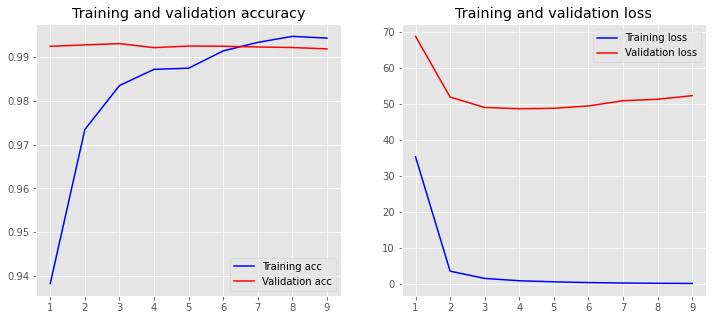

32/32 [==============================] - 10s 221ms/step
F1-score: 72.3%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.8304752572268496,0.6726190476190477,0.7432580574435431,5040.0
Disease,0.7609846479618846,0.6476683937823834,0.6997687720579286,4439.0
micro avg,0.7970737913486005,0.6609346977529276,0.72264836495761,9479.0
macro avg,0.7957299525943671,0.6601437207007155,0.7215134147507358,9479.0
weighted avg,0.7979329200048663,0.6609346977529276,0.7228920971284526,9479.0

!!!!!! Starting model number 3 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 3000
Points in y_train after augmentation: 3000
Converted 11413 words (8099 misses)
Model: "sequential_42"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_42 (Embedding)    (None, 651, 100)          1951300   
                                                                 
 bidirectional_42 (Bidirecti  (None, 651, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_42 (TimeDi  (None, 651, 5)           1005      
 stributed)                                                      
                                                                 
 crf_42 (CRF)                (None, 651, 5)            25        
                                                                 
Total params: 2,113,130
Trainable params: 2,113,130
Non-trainab

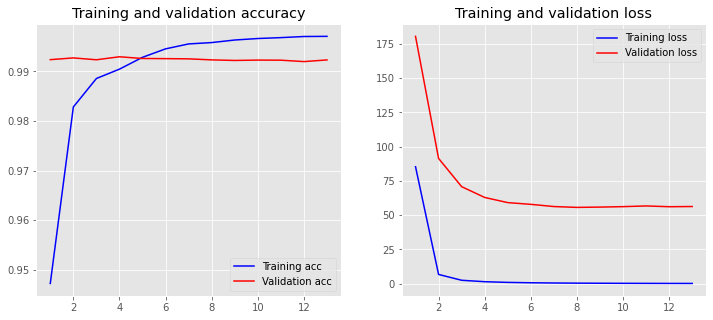

32/32 [==============================] - 10s 230ms/step
F1-score: 72.7%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.8377491207502931,0.7089285714285715,0.7679742074153681,5040.0
Disease,0.6990084985835694,0.6670421266050912,0.6826512968299712,4439.0
micro avg,0.7686154570050582,0.689313218693955,0.7268075639599556,9479.0
macro avg,0.7683788096669313,0.6879853490168313,0.7253127521226697,9479.0
weighted avg,0.772777117184718,0.689313218693955,0.7280176297079541,9479.0

!!!!!! Starting model number 4 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 3000
Points in y_train after augmentation: 3000
Converted 11378 words (8055 misses)
Model: "sequential_43"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_43 (Embedding)    (None, 651, 100)          1943400   
                                                                 
 bidirectional_43 (Bidirecti  (None, 651, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_43 (TimeDi  (None, 651, 5)           1005      
 stributed)                                                      
                                                                 
 crf_43 (CRF)                (None, 651, 5)            25        
                                                                 
Total params: 2,105,230
Trainable params: 2,105,230
Non-trainab

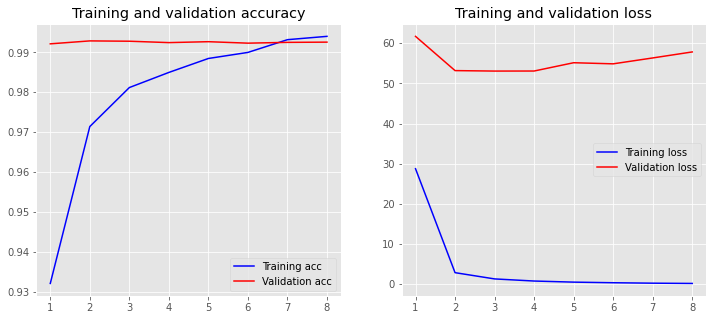

32/32 [==============================] - 10s 227ms/step
F1-score: 73.1%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.9023479188900747,0.671031746031746,0.7696859353664086,5040.0
Disease,0.7217327459618208,0.6643388150484343,0.6918475073313783,4439.0
micro avg,0.8081439877457237,0.6678974575377149,0.7313579391208918,9479.0
macro avg,0.8120403324259478,0.6676852805400901,0.7307667213488935,9479.0
weighted avg,0.8177661325593945,0.6678974575377149,0.7332343284408365,9479.0

!!!!!! Starting model number 5 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 3000
Points in y_train after augmentation: 3000
Converted 11399 words (8064 misses)
Model: "sequential_44"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_44 (Embedding)    (None, 651, 100)          1946400   
                                                                 
 bidirectional_44 (Bidirecti  (None, 651, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_44 (TimeDi  (None, 651, 5)           1005      
 stributed)                                                      
                                                                 
 crf_44 (CRF)                (None, 651, 5)            25        
                                                                 
Total params: 2,108,230
Trainable params: 2,108,230
Non-trainab

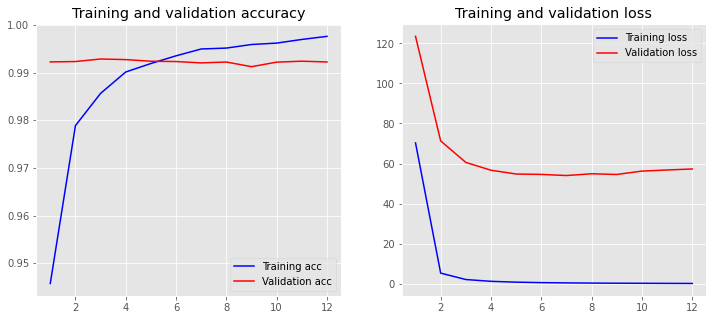

32/32 [==============================] - 10s 220ms/step
F1-score: 71.9%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.7512398333663955,0.7513888888888889,0.7513143537347485,5040.0
Disease,0.6879595588235294,0.6744762333858977,0.6811511773404618,4439.0
micro avg,0.7219205791546897,0.7153708197067201,0.7186307757524375,9479.0
macro avg,0.7195996960949624,0.7129325611373933,0.7162327655376052,9479.0
weighted avg,0.7216057856086382,0.7153708197067201,0.718457054440072,9479.0

!!!!!! Starting model number 6 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 3000
Points in y_train after augmentation: 3000
Converted 11393 words (8076 misses)
Model: "sequential_45"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_45 (Embedding)    (None, 651, 100)          1947000   
                                                                 
 bidirectional_45 (Bidirecti  (None, 651, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_45 (TimeDi  (None, 651, 5)           1005      
 stributed)                                                      
                                                                 
 crf_45 (CRF)                (None, 651, 5)            25        
                                                                 
Total params: 2,108,830
Trainable params: 2,108,830
Non-trainab

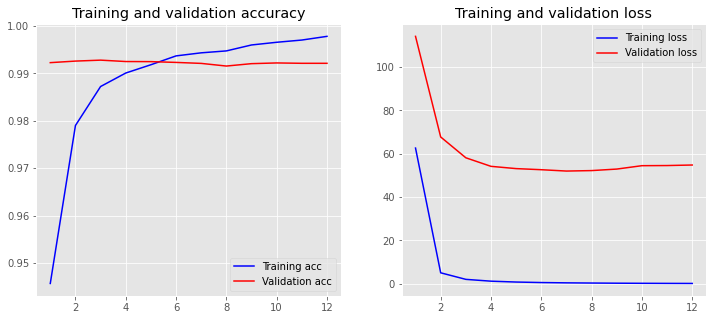

32/32 [==============================] - 10s 221ms/step
F1-score: 71.7%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.7538891104906262,0.75,0.7519395265565944,5040.0
Disease,0.6742678291974067,0.679432304573102,0.6768402154398563,4439.0
micro avg,0.716348687677875,0.7169532651123536,0.7166508488874828,9479.0
macro avg,0.7140784698440165,0.714716152286551,0.7143898709982253,9479.0
weighted avg,0.716602596337171,0.7169532651123536,0.7167706435470785,9479.0

!!!!!! Starting model number 7 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 3000
Points in y_train after augmentation: 3000
Converted 11389 words (8056 misses)
Model: "sequential_46"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_46 (Embedding)    (None, 651, 100)          1944600   
                                                                 
 bidirectional_46 (Bidirecti  (None, 651, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_46 (TimeDi  (None, 651, 5)           1005      
 stributed)                                                      
                                                                 
 crf_46 (CRF)                (None, 651, 5)            25        
                                                                 
Total params: 2,106,430
Trainable params: 2,106,430
Non-trainab

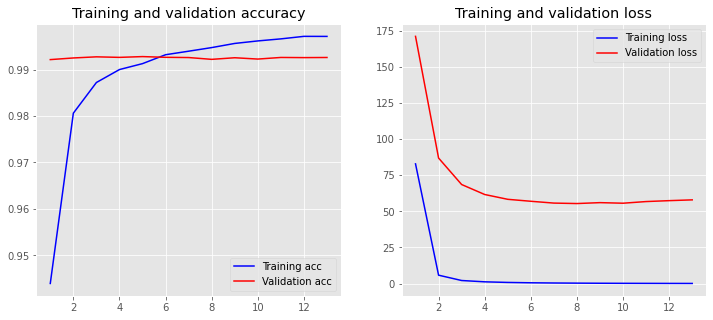

32/32 [==============================] - 10s 214ms/step
F1-score: 72.0%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.8120559248223699,0.7029761904761904,0.7535892800170158,5040.0
Disease,0.6995294117647058,0.6697454381617481,0.6843134998273679,4439.0
micro avg,0.7565308254963428,0.6874142842071949,0.7203183727614415,9479.0
macro avg,0.7557926682935379,0.6863608143189692,0.7189513899221918,9479.0
weighted avg,0.7593599451343257,0.6874142842071949,0.7211475468951837,9479.0

!!!!!! Starting model number 8 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 3000
Points in y_train after augmentation: 3000
Converted 11381 words (8075 misses)
Model: "sequential_47"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_47 (Embedding)    (None, 651, 100)          1945700   
                                                                 
 bidirectional_47 (Bidirecti  (None, 651, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_47 (TimeDi  (None, 651, 5)           1005      
 stributed)                                                      
                                                                 
 crf_47 (CRF)                (None, 651, 5)            25        
                                                                 
Total params: 2,107,530
Trainable params: 2,107,530
Non-trainab

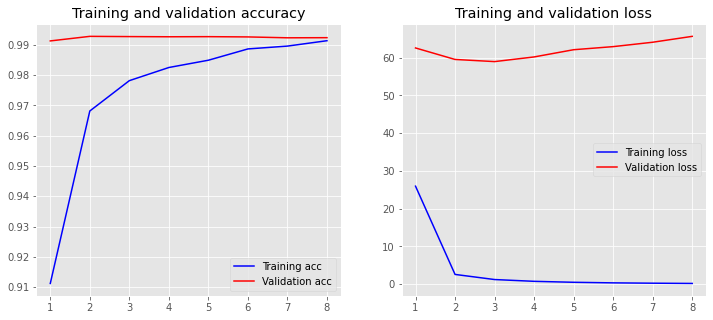

32/32 [==============================] - 19s 525ms/step
F1-score: 73.4%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.7577448527996922,0.7813492063492063,0.7693660252026961,5040.0
Disease,0.717855409995148,0.6665915746789818,0.6912743838336642,4439.0
micro avg,0.7401008691919734,0.7276083975102859,0.7338014682413022,9479.0
macro avg,0.7378001313974201,0.7239703905140941,0.7303202045181802,9479.0
weighted avg,0.7390646928029233,0.7276083975102859,0.7327958388922063,9479.0

!!!!!! Starting model number 9 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 3000
Points in y_train after augmentation: 3000
Converted 11338 words (8079 misses)
Model: "sequential_48"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_48 (Embedding)    (None, 651, 100)          1941800   
                                                                 
 bidirectional_48 (Bidirecti  (None, 651, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_48 (TimeDi  (None, 651, 5)           1005      
 stributed)                                                      
                                                                 
 crf_48 (CRF)                (None, 651, 5)            25        
                                                                 
Total params: 2,103,630
Trainable params: 2,103,630
Non-trainab

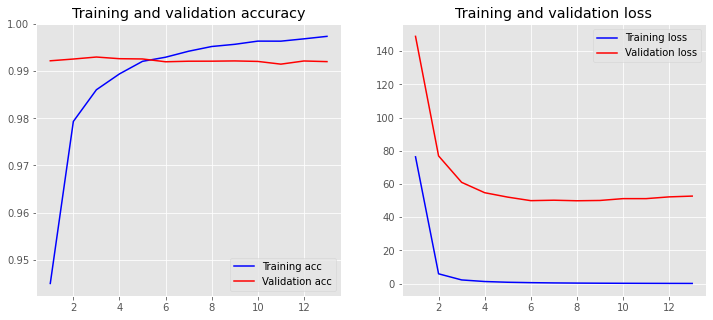

32/32 [==============================] - 10s 227ms/step
F1-score: 71.9%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.7584830339321357,0.753968253968254,0.7562189054726367,5040.0
Disease,0.6812386156648452,0.6740256814597883,0.6776129543653041,4439.0
micro avg,0.7223994894703255,0.7165312796708514,0.719453418780785,9479.0
macro avg,0.7198608247984905,0.7139969677140211,0.7169159299189705,9479.0
weighted avg,0.7223096007969418,0.7165312796708514,0.7194078687635482,9479.0

!!!!!! Starting model number 10 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 3000
Points in y_train after augmentation: 3000
Converted 11382 words (8058 misses)
Model: "sequential_49"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_49 (Embedding)    (None, 651, 100)          1944100   
                                                                 
 bidirectional_49 (Bidirecti  (None, 651, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_49 (TimeDi  (None, 651, 5)           1005      
 stributed)                                                      
                                                                 
 crf_49 (CRF)                (None, 651, 5)            25        
                                                                 
Total params: 2,105,930
Trainable params: 2,105,930
Non-trainab

In [ ]:
number_of_training_models = 10
target_augmented_percentage = 2

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 200% !!!!!!
!!!!!! Starting model number 1 !!!!!!


Downloading:   0%|          | 0.00/442M [00:00<?, ?B/s]

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 3000
Points in y_train after augmentation: 3000
Converted 11346 words (8006 misses)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 651, 100)          1935300   
                                                                 
 bidirectional (Bidirectiona  (None, 651, 200)         160800    
 l)                                                              
                                                                 
 time_distributed (TimeDistr  (None, 651, 5)           1005      
 ibuted)                                                         
                                                                 
 crf (CRF)                   (None, 651, 5)            25        
                                                                 
Total params: 2,097,130
Trainable params: 2,097,130
Non-trainable 

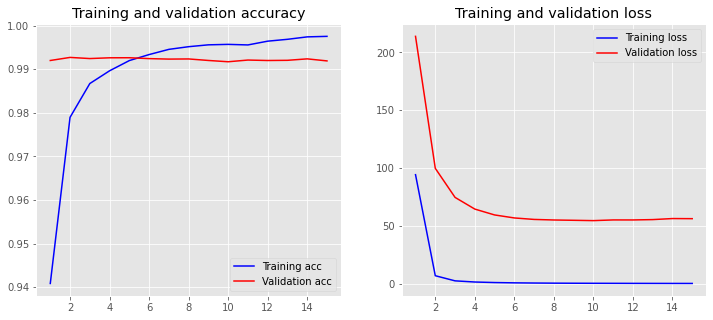

32/32 [==============================] - 9s 205ms/step
F1-score: 71.3%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.7810457516339869,0.7113095238095238,0.7445482866043613,5040.0
Disease,0.6930298052100445,0.6652399189006533,0.6788505747126437,4439.0
micro avg,0.7386735962038188,0.6897352041354573,0.7133660665575559,9479.0
macro avg,0.7370377784220157,0.6882747213550886,0.7116994306585025,9479.0
weighted avg,0.7398280297038381,0.6897352041354573,0.7137821569401209,9479.0



In [13]:
number_of_training_models = 1
target_augmented_percentage = 2

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 500% !!!!!!
!!!!!! Starting model number 1 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 6000
Points in y_train after augmentation: 6000
Converted 11871 words (8372 misses)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 651, 100)          2024400   
                                                                 
 bidirectional_1 (Bidirectio  (None, 651, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_1 (TimeDis  (None, 651, 5)           1005      
 tributed)                                                       
                                                                 
 crf_1 (CRF)                 (None, 651, 5)            25        
                                                                 
Total params: 2,186,230
Trainable params: 2,186,230
Non-trainabl

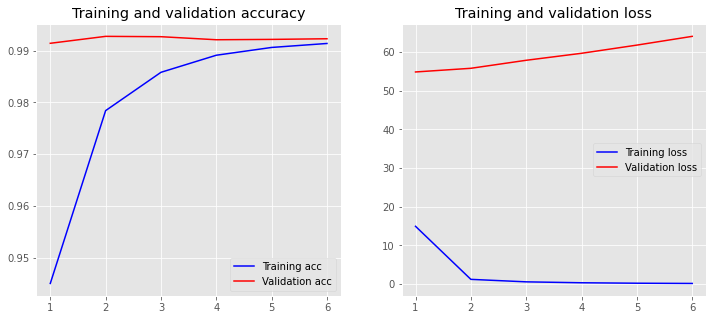

32/32 [==============================] - 9s 200ms/step
F1-score: 68.7%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.8327440848517813,0.6075396825396825,0.7025352758976713,5040.0
Disease,0.6972053462940462,0.646316738004055,0.6707972878185644,4439.0
micro avg,0.7611652977412731,0.6256989133874882,0.6868160500260553,9479.0
macro avg,0.7649747155729137,0.6269282102718687,0.6866662818581178,9479.0
weighted avg,0.7692715180770385,0.6256989133874882,0.6876724286476285,9479.0

!!!!!! Starting model number 2 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 6000
Points in y_train after augmentation: 6000
Converted 11793 words (8351 misses)
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 651, 100)          2014500   
                                                                 
 bidirectional_2 (Bidirectio  (None, 651, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_2 (TimeDis  (None, 651, 5)           1005      
 tributed)                                                       
                                                                 
 crf_2 (CRF)                 (None, 651, 5)            25        
                                                                 
Total params: 2,176,330
Trainable params: 2,176,330
Non-trainabl

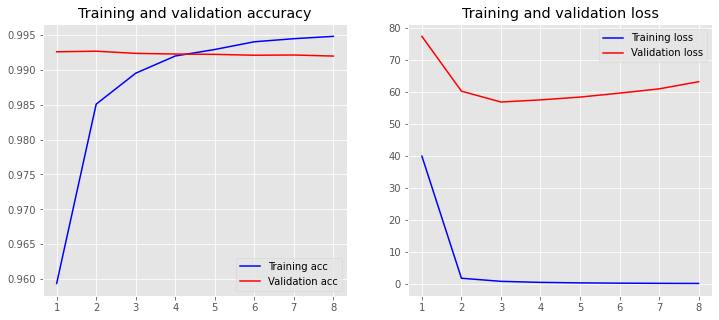

32/32 [==============================] - 10s 208ms/step
F1-score: 72.5%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.8792969759627811,0.675,0.7637220787967225,5040.0
Disease,0.707177033492823,0.6659157467898176,0.6859264415825503,4439.0
micro avg,0.7899117902845074,0.6707458592678552,0.7254678229119124,9479.0
macro avg,0.7932370047278021,0.6704578733949088,0.7248242601896364,9479.0
weighted avg,0.7986934919851312,0.6707458592678552,0.727290510741684,9479.0

!!!!!! Starting model number 3 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 6000
Points in y_train after augmentation: 6000
Converted 11825 words (8391 misses)
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 651, 100)          2021700   
                                                                 
 bidirectional_3 (Bidirectio  (None, 651, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_3 (TimeDis  (None, 651, 5)           1005      
 tributed)                                                       
                                                                 
 crf_3 (CRF)                 (None, 651, 5)            25        
                                                                 
Total params: 2,183,530
Trainable params: 2,183,530
Non-trainabl

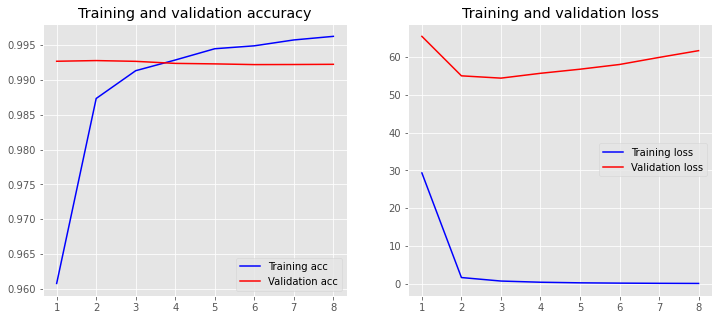

32/32 [==============================] - 10s 207ms/step
F1-score: 72.6%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.8775457592162929,0.6753968253968254,0.7633142729005495,5040.0
Disease,0.7263556116015133,0.6487947735976571,0.6853879105188007,4439.0
micro avg,0.8011218765935747,0.6629391286000633,0.7255094383189978,9479.0
macro avg,0.8019506854089031,0.6620957994972413,0.7243510917096752,9479.0
weighted avg,0.8067436635034533,0.6629391286000633,0.7268214864660539,9479.0

!!!!!! Starting model number 4 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 6000
Points in y_train after augmentation: 6000
Converted 11819 words (8358 misses)
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 651, 100)          2017800   
                                                                 
 bidirectional_4 (Bidirectio  (None, 651, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_4 (TimeDis  (None, 651, 5)           1005      
 tributed)                                                       
                                                                 
 crf_4 (CRF)                 (None, 651, 5)            25        
                                                                 
Total params: 2,179,630
Trainable params: 2,179,630
Non-trainabl

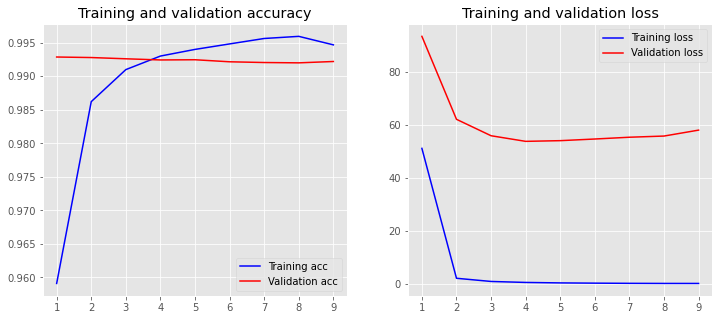

32/32 [==============================] - 9s 203ms/step
F1-score: 73.1%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.8793371310201968,0.6738095238095239,0.7629746124466413,5040.0
Disease,0.7390755241222531,0.6591574678981753,0.6968325791855203,4439.0
micro avg,0.8083365298555172,0.6669479902943348,0.7308670520231214,9479.0
macro avg,0.8092063275712249,0.6664834958538496,0.7299035958160809,9479.0
weighted avg,0.8136528528241875,0.6669479902943348,0.7320004078210356,9479.0

!!!!!! Starting model number 5 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 6000
Points in y_train after augmentation: 6000
Converted 11776 words (8342 misses)
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 651, 100)          2011900   
                                                                 
 bidirectional_5 (Bidirectio  (None, 651, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_5 (TimeDis  (None, 651, 5)           1005      
 tributed)                                                       
                                                                 
 crf_5 (CRF)                 (None, 651, 5)            25        
                                                                 
Total params: 2,173,730
Trainable params: 2,173,730
Non-trainabl

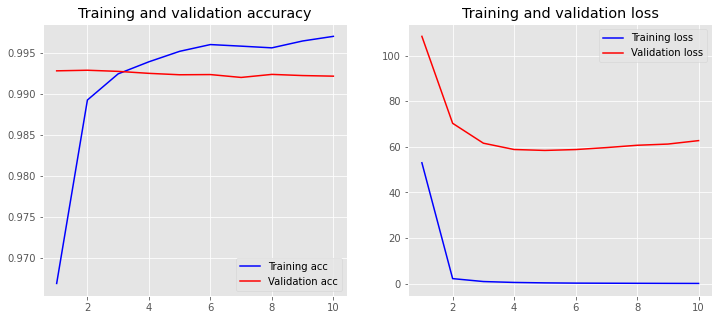

32/32 [==============================] - 10s 208ms/step
F1-score: 72.4%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.8266635093535402,0.6926587301587301,0.7537514844003023,5040.0
Disease,0.7360264227642277,0.6526244649695877,0.691820895522388,4439.0
micro avg,0.7829390856722638,0.6739107500791223,0.7243451638507769,9479.0
macro avg,0.7813449660588839,0.6726415975641589,0.7227861899613451,9479.0
weighted avg,0.7842183118253244,0.6739107500791223,0.724749492203967,9479.0

!!!!!! Starting model number 6 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 6000
Points in y_train after augmentation: 6000
Converted 11841 words (8389 misses)
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 651, 100)          2023100   
                                                                 
 bidirectional_6 (Bidirectio  (None, 651, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_6 (TimeDis  (None, 651, 5)           1005      
 tributed)                                                       
                                                                 
 crf_6 (CRF)                 (None, 651, 5)            25        
                                                                 
Total params: 2,184,930
Trainable params: 2,184,930
Non-trainabl

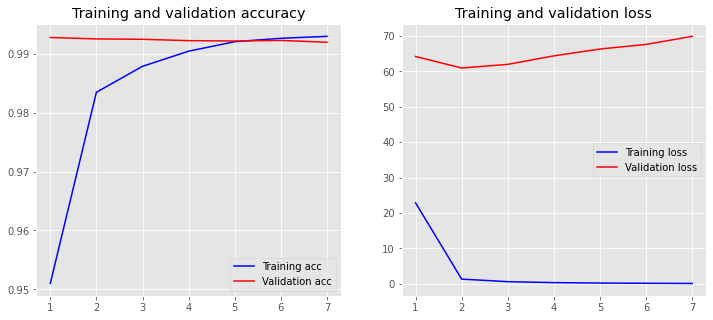

32/32 [==============================] - 10s 209ms/step
F1-score: 72.4%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.8666832793421381,0.6900793650793651,0.7683640782061195,5040.0
Disease,0.7307994757536042,0.6280693849966209,0.6755512478798158,4439.0
micro avg,0.8004598875830352,0.6610401941133031,0.7241000751141157,9479.0
macro avg,0.7987413775478711,0.659074375037993,0.7219576630429676,9479.0
weighted avg,0.803049119185001,0.6610401941133031,0.7248999834895394,9479.0

!!!!!! Starting model number 7 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 6000
Points in y_train after augmentation: 6000
Converted 11797 words (8337 misses)
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 651, 100)          2013500   
                                                                 
 bidirectional_7 (Bidirectio  (None, 651, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_7 (TimeDis  (None, 651, 5)           1005      
 tributed)                                                       
                                                                 
 crf_7 (CRF)                 (None, 651, 5)            25        
                                                                 
Total params: 2,175,330
Trainable params: 2,175,330
Non-trainabl

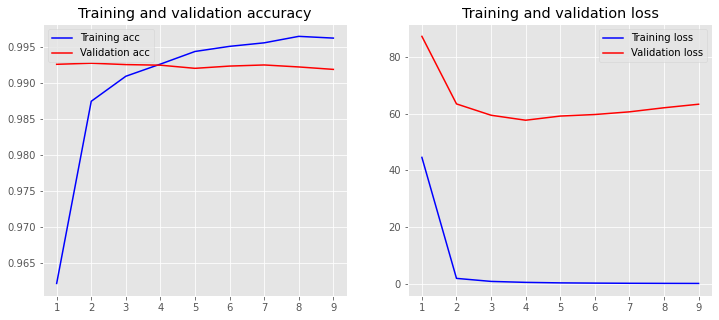

32/32 [==============================] - 10s 214ms/step
F1-score: 72.6%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.8561490683229813,0.6837301587301587,0.7602868174296745,5040.0
Disease,0.7176355642403517,0.6618607794548321,0.6886206492441109,4439.0
micro avg,0.7863037319866979,0.67348876463762,0.7255369928400954,9479.0
macro avg,0.7868923162816666,0.6727954690924954,0.7244537333368928,9479.0
weighted avg,0.7912834237800134,0.67348876463762,0.7267256695685377,9479.0

!!!!!! Starting model number 8 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 6000
Points in y_train after augmentation: 6000
Converted 11842 words (8352 misses)
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 651, 100)          2019500   
                                                                 
 bidirectional_8 (Bidirectio  (None, 651, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_8 (TimeDis  (None, 651, 5)           1005      
 tributed)                                                       
                                                                 
 crf_8 (CRF)                 (None, 651, 5)            25        
                                                                 
Total params: 2,181,330
Trainable params: 2,181,330
Non-trainabl

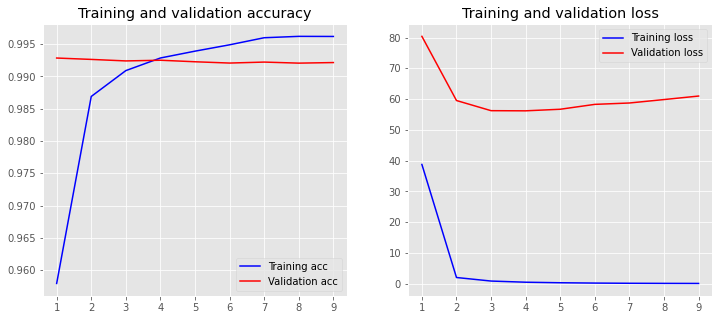

32/32 [==============================] - 10s 207ms/step
F1-score: 72.7%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.8616194534971171,0.6819444444444445,0.7613246206667406,5040.0
Disease,0.7468454258675079,0.6400090110385221,0.6893121436370253,4439.0
micro avg,0.8055947645322725,0.6623061504378099,0.7269569245020842,9479.0
macro avg,0.8042324396823125,0.6609767277414833,0.7253183821518829,9479.0
weighted avg,0.8078709664575734,0.6623061504378099,0.7276012969474763,9479.0

!!!!!! Starting model number 9 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 6000
Points in y_train after augmentation: 6000
Converted 11816 words (8364 misses)
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 651, 100)          2018100   
                                                                 
 bidirectional_9 (Bidirectio  (None, 651, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_9 (TimeDis  (None, 651, 5)           1005      
 tributed)                                                       
                                                                 
 crf_9 (CRF)                 (None, 651, 5)            25        
                                                                 
Total params: 2,179,930
Trainable params: 2,179,930
Non-trainabl

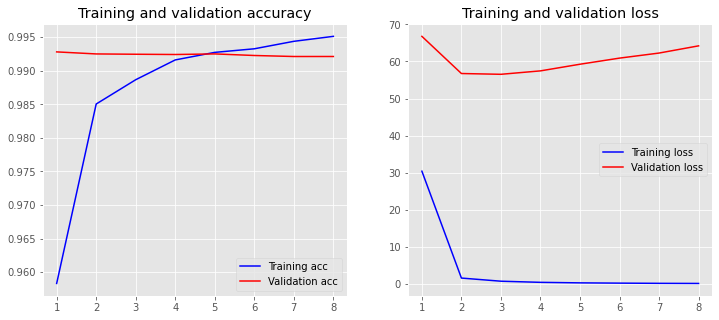

32/32 [==============================] - 10s 210ms/step
F1-score: 73.1%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.8622244488977956,0.682936507936508,0.7621789193976972,5040.0
Disease,0.7403482210446631,0.6609596756026132,0.6984051416329445,4439.0
micro avg,0.8015084852294154,0.6726447937546155,0.7314443042331078,9479.0
macro avg,0.8012863349712294,0.6719480917695606,0.7302920305153209,9479.0
weighted avg,0.8051500132568994,0.6726447937546155,0.7323137648985161,9479.0

!!!!!! Starting model number 10 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 6000
Points in y_train after augmentation: 6000
Converted 11799 words (8364 misses)
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 651, 100)          2016400   
                                                                 
 bidirectional_10 (Bidirecti  (None, 651, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_10 (TimeDi  (None, 651, 5)           1005      
 stributed)                                                      
                                                                 
 crf_10 (CRF)                (None, 651, 5)            25        
                                                                 
Total params: 2,178,230
Trainable params: 2,178,230
Non-trainab

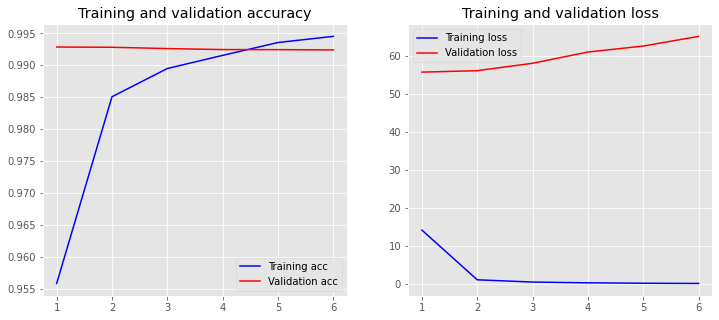

32/32 [==============================] - 10s 212ms/step
F1-score: 73.1%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.9139522258414766,0.6680555555555555,0.7718936267767078,5040.0
Disease,0.7156030089784033,0.6643388150484343,0.6890186915887851,4439.0
micro avg,0.8092248558616272,0.6663150121320814,0.7308493404304559,9479.0
macro avg,0.8147776174099399,0.6661971853019949,0.7304561591827465,9479.0
weighted avg,0.8210656161088906,0.6663150121320814,0.7330834318933669,9479.0



In [14]:
number_of_training_models = 10
target_augmented_percentage = 5

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)